<a href="https://colab.research.google.com/github/ericthansen/dsc-phase-4-project_work/blob/main/project4_technical_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4


Classification/prediction of text reviews is a useful tool for many different fields and is a perfect application of Natural Language Processing (NLP) techniques within Machine Learning/Deep Learning.  

In this case, we will attend to video game reviews on the Steam platform (a digital distribution service and storefront developed by Valve).  Launched in 2003, users are able to purchase and download games from Steam, as well as use their cloud storage to backup saved games for use across multiple devices.  As of March 29, 2022, Steam reports over 27 million concurrent users at peak logged in to their service, with over 120 million users total.   



Currently, users are able to supply "would recommend"/"would not recommend" binary ratings, along with text reviews of games on Steam.  This provides us with a data set of labeled data from which to begin.

Stakeholders in this process include (but aren't limited to)
- Valve (or other digital distributors, e.g. Epic Games, Apple App Store, Google Play), 
- video game developers/publishers, 
- video game consumers (including reviewers, critics, players, streamers, etc.), 
- computer hardware manufacturers (knowledge about what games are popular could drive  video card architecture, e.g.)  
- cultural linguists (due to the nuanced and specialized vernacular exhibited by video gaming communities).

Business problems that such an investigation could illuminate include:
- validation of new ratings (i.e. checking consistency between user text and user binary rating).  This could be helpful for several reasons.  
    - Prompting users to double-check that they provided the intended binary rating, if their text review seems inconsistent.  
    - Notifying Valve of potential abuse/manipulation of the rating system, in the event that users are repeatedly providing inconsistent rating/review combinations.  
- automatically applying a binary rating to unlabeled reviews, which might be accessible, for example, from scrubbing the web for other game reviews.  

- generating a more nuanced rating number for each review than just 0 or 1; this could be more representative when aggregating the reviews.  
    - For example, a game which received three reviews, two that were just slightly negative and one very positive would receive binary scores of 0, 0, and 1, while receiving nuanced scores of .4, .4, and .9.  Another game could receive two very negative reviews and one slightly positive one and receive the same binary scores, (0, 0, 1) but receive different nuanced scores, .1, .1, and .6.  In aggregate, the binary system would rank these games the same, but would give a higher average nuanced rating to the former game.



In [ ]:
# Useful global flags
SINGLE_SOURCE = False
 # this is used to either use only raw data, or to include options for cleaned/stemmed/lemmatized data - 
 # warning - if this is turned False, it increases run time

In [ ]:
#GloVe Set-up - 
# 0) Acquire glove zipped file and put on google drive to use with Colab

# 1) unzip
##only run the following lines once!
from google.colab import drive
drive.mount('/content/gdrive')
#### !unzip gdrive/My\ Drive/DataSciUploads/GloVe/glove.840B.300d.zip


# 2) make file available
#GLOVE_PATH = '/content/gdrive/MyDrive/DataSciUploads/GloVe/glove.840B.300d.txt'
GLOVE_PATH = '/content/gdrive/MyDrive/DataSciUploads/GloVe/glove.6B.300d.txt'


Mounted at /content/gdrive


In [ ]:
import xgboost as xgb

In [ ]:
from xgboost import XGBClassifier

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Ensure to download spacy and the corresponding package
# pip install -U spacy
# python -m spacy download en_core_web_sm

import spacy
spacy_nlp = spacy.load('en_core_web_sm')

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  pass
  #raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
#Not necessary to run every time - just a check on GPU performance
# # testing GPU speedup
# %tensorflow_version 2.x
# import tensorflow as tf
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [ ]:
#Colab GPU Status check
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 22 03:17:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |    336MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Colab RAM-type check
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 

import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

#must ensure conda install py-xgboost
#import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
try:
  from keras.layers.recurrent import LSTM, GRU, SimpleRNN
except:
  from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
try:
  from keras.layers.embeddings import Embedding
except:
  from keras.layers import Embedding
from keras.layers import BatchNormalization # keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, RepeatVector
from keras.preprocessing import sequence, text #sequence is deprecated
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import nltk 
from nltk.corpus import stopwords 
import string
import collections

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from wordcloud import WordCloud
import random

#from sklearn.pipeline import Pipeline
import pickle

import plotly.express as px



In [ ]:
!pip install -q swifter
import swifter

     |████████████████████████████████| 830 kB 35.5 MB/s 
     |████████████████████████████████| 280 kB 89.6 MB/s 
     |████████████████████████████████| 1.6 MB 95.2 MB/s 


# Loading Data

In [ ]:
train_url = 'https://github.com/ericthansen/dsc-phase-4-project_work/blob/main/data/train.csv?raw=true'
test_url = 'https://github.com/ericthansen/dsc-phase-4-project_work/blob/main/data/test.csv?raw=true'


In [ ]:
train_df = pd.read_csv(train_url)#'./data/train.csv')
test_df = pd.read_csv(test_url)#'./data/test.csv')


# Initial Data Investigation 

In [ ]:
train_df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


In [ ]:
train_df.describe()

,review_id,year,user_suggestion
count,17494.000000,17316.000000,17494.000000
mean,12423.216989,2016.388427,0.569795
std,7653.367660,1.390356,0.495119
min,1.000000,2011.000000,0.000000
25%,5769.250000,2015.000000,0.000000
50%,11756.500000,2017.000000,1.000000
75%,18926.750000,2018.000000,1.000000
max,25539.000000,2018.000000,1.000000


In [ ]:
test_df.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


Note that Test set doesn't actually have labels, so we can't really use it as a test set. We will have to split train_df into train/valid/test.

In [ ]:
train_df.sample(5)

,review_id,title,year,user_review,user_suggestion
15612,23047,AdventureQuest 3D,2017.0,Early Access ReviewI am still very much on the...,1
9686,13270,Realm of the Mad God,2015.0,I have WAY more gametime then it says. I play ...,1
17199,25245,School of Dragons,2015.0,…………………….…………...„--~*'¯…….'\ ………….…………………… („-...,0
5957,8332,DCS World Steam Edition,2018.0,"Very fun to play, steep learning curve, but th...",1
15561,22996,AdventureQuest 3D,2016.0,Early Access ReviewI do recommand this game. I...,1


In [ ]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8045 entries, 0 to 8044
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    8045 non-null   int64  
 1   title        8045 non-null   object 
 2   year         7978 non-null   float64
 3   user_review  8045 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 251.5+ KB


None

In [ ]:
display(train_df.isna().sum())
display(test_df.isna().sum())
#year has some invalid entries, but we won't be using those.

review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64

review_id       0
title           0
year           67
user_review     0
dtype: int64

Really what we are concerned with here is the user_review (predictor) and user_suggestion (target) columns, the rest we can drop.  But first, let's just check out the distribution by year.

In [ ]:
train_df['year'].value_counts()
#so the data is mostly within the last 4 years of data (though a refreshed data pull could be useful for future work)

2018.0    4822
2016.0    4226
2017.0    3890
2015.0    2460
2014.0    1499
2013.0     340
2012.0      65
2011.0      14
Name: year, dtype: int64

In [ ]:
#check distribution of value counts
train_df['user_suggestion'].value_counts()
#so there is a little imbalance, we could ignore it or rebalance by resampling.
#generally, resampling is only necessary when the imbalance is on the order of 1:10 - ours is much less severe than that.


1    9968
0    7526
Name: user_suggestion, dtype: int64

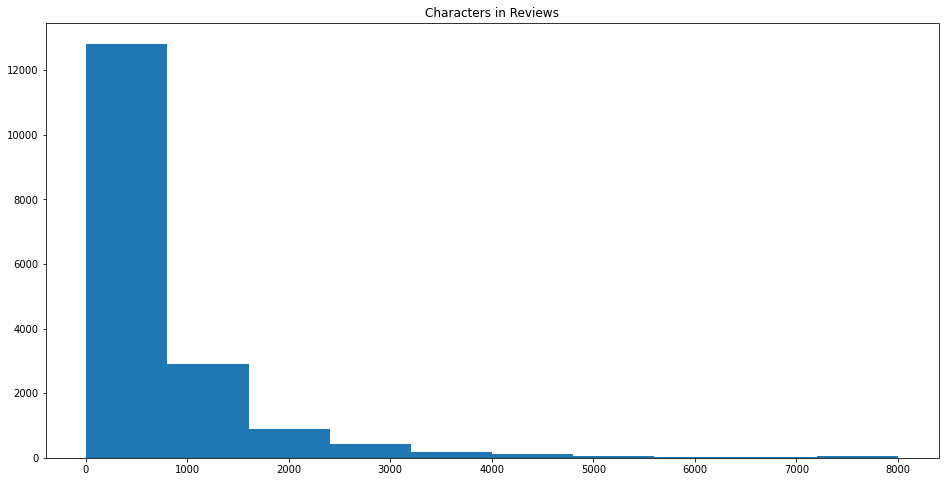

In [ ]:
#Number of characters
class_len = train_df['user_review'].str.len()

plt.figure(figsize=(16,8))
plt.hist(class_len)
plt.title('Characters in Reviews')

plt.show()

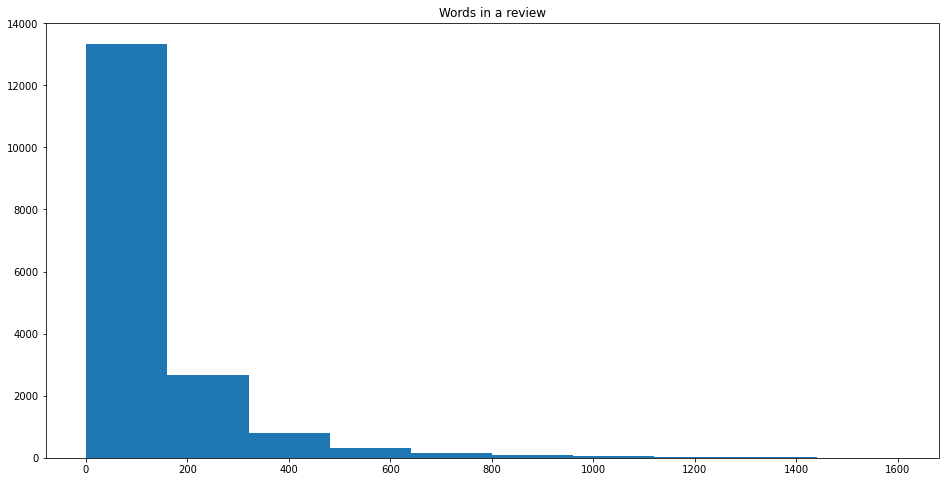

In [ ]:
class_len = train_df['user_review'].str.split().map(lambda text: len(text))

plt.figure(figsize=(16,8))
plt.hist(class_len)
plt.title('Words in a review')

plt.show()

In [ ]:
STOPWORDS = stopwords.words('english')
print(STOPWORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def create_corpus(sug=None):
    #print('sugg',sug)
    if sug==None:#all reviews
        corpus = []
        for sentence in train_df['user_review'].str.split():
            for word in sentence:
                corpus.append(word.lower())

        return corpus
    elif sug == 0: #negative reviews
        corpus = []
        for sentence in train_df[train_df['user_suggestion'] == sug]['user_review'].str.split():
            for word in sentence:
                corpus.append(word.lower())

        return corpus
    elif sug == 1: #positive reviews
        corpus = []
        for sentence in train_df[train_df['user_suggestion'] == sug]['user_review'].str.split():
            for word in sentence:
                corpus.append(word.lower())

        return corpus

<BarContainer object of 20 artists>

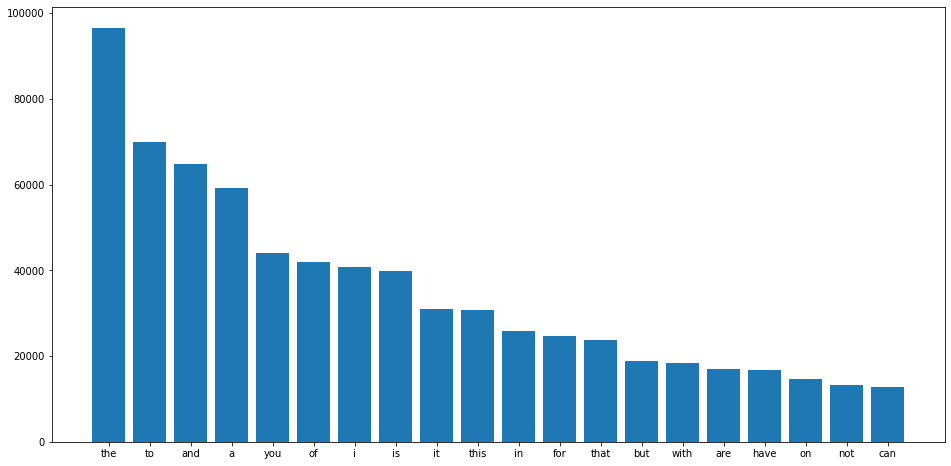

In [ ]:
#Look at top 20 most common stopwords in our data
corpus = create_corpus()
dic = collections.defaultdict(int)

for word in corpus:
    if word in STOPWORDS:
        dic[word] += 1

x, y = zip(*sorted(dic.items(), key=lambda word: word[1], reverse=True)[:20])

plt.figure(figsize=(16, 8))
plt.bar(x, y)

There is nothing alarming with the stop-words.

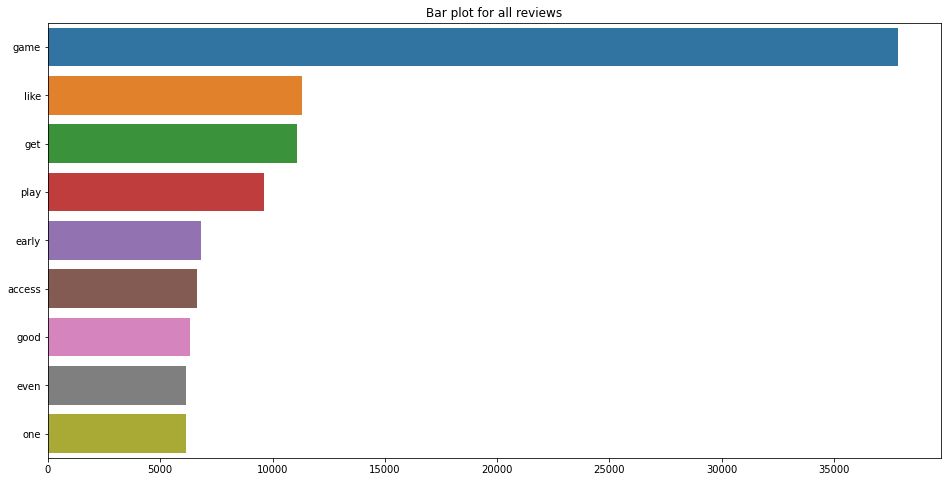

In [ ]:
#Plot the most common words in review
corpus = create_corpus()
counter = collections.Counter(corpus)
most_common = counter.most_common()

x, y = [], []

for word, count in most_common[:50]:
    if word not in STOPWORDS:
        x.append(word)
        y.append(count)
#import seaborn as sns 

plt.figure(figsize=(16, 8))
plt.title('Bar plot for all reviews')
sns.barplot(x=y, y=x)

In [ ]:
#Add a color theme for the following wordcloud:
def purple_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl({}, {}%, {}%)".format(random.randint(220,330), random.randint(60, 80), random.randint(60, 80))
            #"hsl(0, 0%%, %d%%)" % random.randint(60, 100)


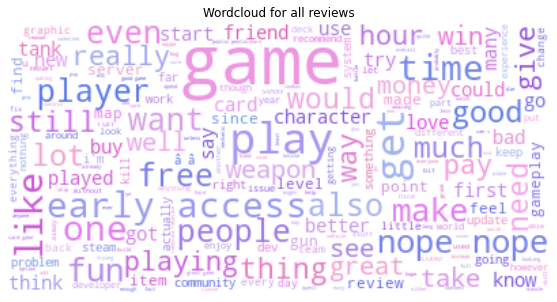

In [ ]:
#Everybody loves a good word cloud
from wordcloud import WordCloud
corpus = create_corpus()
all_words = ' '.join(corpus) 

wordcloud = WordCloud(max_font_size=50, background_color='white', color_func=purple_color_func, stopwords=STOPWORDS).generate(all_words)

plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for all reviews')

plt.show()

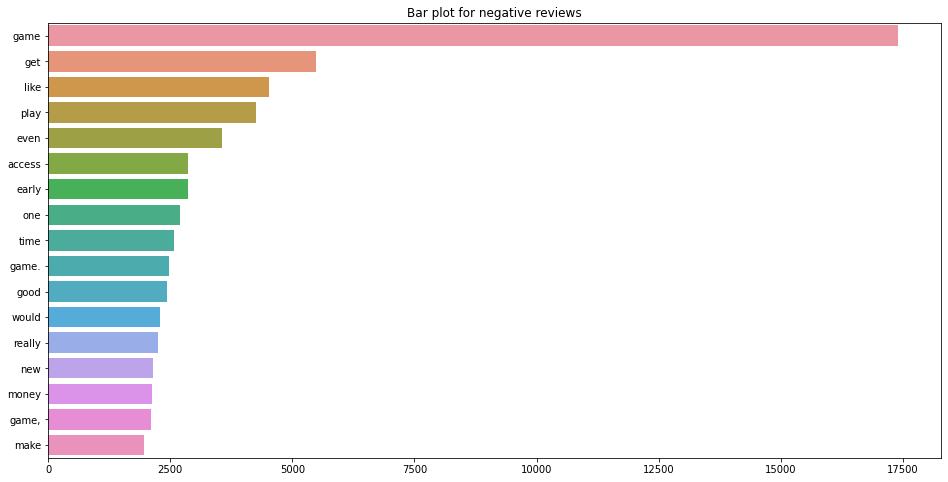

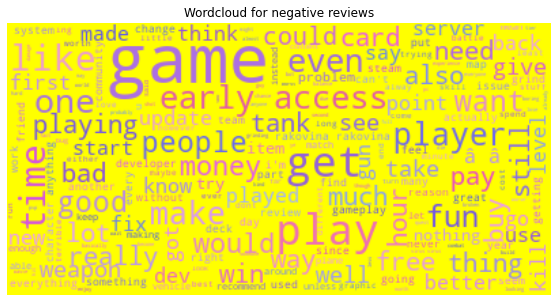

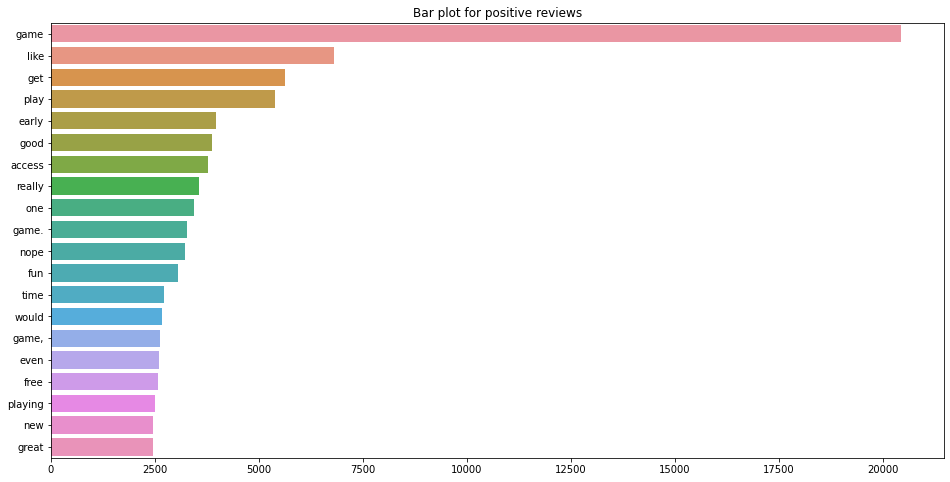

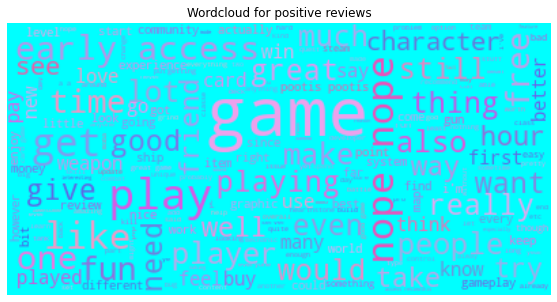

In [ ]:
#Let's check out word frequency for negative-only and positive-only reviews as well
for i in range(0,2):
    
    #Plot the most common words in review
    corpus = create_corpus(i)
    counter = collections.Counter(corpus)
    most_common = counter.most_common()

    x, y = [], []

    #print(most_common[:75])
    for word, count in most_common[:75]:
        if word not in STOPWORDS:
            x.append(word)
            y.append(count)
    #import seaborn as sns 
    if i==0:
        neg_top_10=[x[:10], y[:10]]
    elif i==1:
        pos_top_10=[x[:10], y[:10]]

    plt.figure(figsize=(16, 8))
    sns.barplot(x=y, y=x)
    plt.title('Bar plot for {} reviews'.format('positive' if i==1 else 'negative'))

    #Everybody loves a good word cloud
    from wordcloud import WordCloud

    all_words = ' '.join(corpus) 
    
    bc='cyan' if i==1 else 'yellow'
    wordcloud = WordCloud(max_font_size=50, background_color=bc, color_func=purple_color_func, stopwords=STOPWORDS).generate(all_words)

    plt.figure(figsize=(15,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Wordcloud for {} reviews'.format('positive' if i==1 else 'negative'))

    plt.show()

Curiously, people use some words most frequently when discussing a game, whether positively or negatively.  If a word count approach is going to be helpful, it will likely tune in on less frequent (but important) words.

In [ ]:
neg_top_10

[['game',
  'get',
  'like',
  'play',
  'even',
  'access',
  'early',
  'one',
  'time',
  'game.'],
 [17411, 5475, 4513, 4260, 3568, 2863, 2858, 2698, 2570, 2469]]

In [ ]:
pos_top_10

[['game',
  'like',
  'get',
  'play',
  'early',
  'good',
  'access',
  'really',
  'one',
  'game.'],
 [20447, 6814, 5631, 5376, 3959, 3884, 3781, 3569, 3432, 3272]]



# Some typical preprocessing:
- Apply lowercase  
- Remove punctuation  
- Remove numbers  
- Remove stopwords  
- Remove white spaces  
- Apply lemmatization  
- and stemming

In [ ]:
#time testing swifter
# not vital to results but interesting to see for reference

# import time

# # get the start time
# st = time.process_time()

# train_df['review_lemma'] = train_df['review_cleaned'].apply(lambda text: lemmatizer_doc(text))

# # get execution time
# et = time.process_time()
# res = et - st
# print('CPU Execution time:', res, 'seconds')


In [ ]:
# #time testing swifter
# st = time.process_time()
# train_df['review_lemma'] = train_df['review_cleaned'].swifter.apply(lambda text: lemmatizer_doc(text))
# et = time.process_time()
# res = et - st
# print('CPU Execution time:', res, 'seconds')

In [ ]:
#Apply lowercase
train_df['review_cleaned'] = train_df['user_review'].apply(lambda text: text.lower())

#Remove punctuation
# def remove_punctuation(sentence):
#     return ''.join([word for word in str(sentence) if word not in string.punctuation])


import string
def remove_punctuation(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))
    
train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_punctuation(text))

#Remove numbers
def remove_numbers(sentence):
    return re.sub(r'\d+', '', sentence)

train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_numbers(text))

#Remove stopwords
def remove_stopwords(sentence):
    return ' '.join([word for word in str(sentence).split() if word not in STOPWORDS])
    
train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_stopwords(text))

#Remove white spaces
def remove_spaces(sentence):
    return re.sub(r'\s+', ' ', sentence).strip()

train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_spaces(text))

if not SINGLE_SOURCE:
    #Apply lemmatization
    spacy_lem = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    def lemmatizer_doc(sentence):
        doc = spacy_lem(sentence)
        new_sentence = [token.lemma_ for token in doc if token.is_alpha]  
        return ' '.join(new_sentence)

    train_df['review_lemma'] = train_df['review_cleaned'].apply(lambda text: lemmatizer_doc(text))

    # Apply stemming
    def stemmer(sentence):
        ps = PorterStemmer()
        return ps.stem(sentence)

    train_df['review_stem'] = train_df['review_cleaned'].apply(lambda text: stemmer(text))

In [ ]:
INSPECT_ROW = 3
print('Original review\n', train_df['user_review'].iloc[INSPECT_ROW])
if not SINGLE_SOURCE:
    print('\nReview clean\n',train_df['review_cleaned'].iloc[INSPECT_ROW])
    print('\nReview lemmatized\n',train_df['review_lemma'].iloc[INSPECT_ROW])
    print('\nReview stemmed\n',train_df['review_stem'].iloc[INSPECT_ROW])

Original review
 Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!

Review clean
 great game fun colorful thata side note though getting windowed mode computer hates fullscreen yeah computer doesnt like run shame really enjoyable guess ill settle skyrim cheers

Review lemmatized
 great game fun colorful thata side note though get windowe mode computer hate fullscreen yeah computer do not like run shame really enjoyable guess ill settle skyrim cheer

Review stemmed
 great game fun colorful thata side note though getting windowed mode computer hates fullscreen yeah computer doesnt like run shame really enjoyable guess ill settle skyrim ch


In [ ]:
#label encode to ensure y plays well with other parts
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train_df.user_suggestion.values)


# Primary Train/Test Split, to create final holdout Test Set.  

The following is to show the concept - which is then done in batches below.
<!--  -->

In [ ]:
X_rem, X_test, y_rem, y_test = train_test_split(train_df.user_review.values,y, test_size=0.1, stratify=y, random_state=42, shuffle=True)


In [ ]:
print(X_rem.shape), print(y_rem.shape)
print(X_test.shape), print(y_test.shape)

(15744,)
(15744,)
(1750,)
(1750,)


(None, None)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_rem,y_rem, test_size=1/9, stratify=y_rem, random_state=42, shuffle=True)

In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)

(13994,)
(13994,)
(1750,)
(1750,)


(None, None)

Now, to split out for raw/clean/lemmatized/stemmed

In [ ]:
if SINGLE_SOURCE:

    X_rem, X_test, y_rem, y_test = train_test_split(train_df.user_review.values,y, test_size=0.1, stratify=y, random_state=42, shuffle=True)
    X_train, X_valid, y_train, y_valid = train_test_split(X_rem,y_rem, test_size=1/9, stratify=y_rem, random_state=42, shuffle=True)
    
    xtrain_raw, xvalid_raw, ytrain_raw, yvalid_raw, xtest_raw, ytest_raw = X_train, X_valid, y_train, y_valid, X_test, y_test
else:

    X_rem, X_test, y_rem, y_test = train_test_split(train_df.user_review.values,y, test_size=0.1, stratify=y, random_state=42, shuffle=True)
    X_train, X_valid, y_train, y_valid = train_test_split(X_rem,y_rem, test_size=1/9, stratify=y_rem, random_state=42, shuffle=True)  
    xtrain_raw, xvalid_raw, ytrain_raw, yvalid_raw, xtest_raw, ytest_raw = X_train, X_valid, y_train, y_valid, X_test, y_test
    ##

    X_rem, X_test, y_rem, y_test = train_test_split(train_df.review_cleaned.values,y, test_size=0.1, stratify=y, random_state=42, shuffle=True)
    X_train, X_valid, y_train, y_valid = train_test_split(X_rem,y_rem, test_size=1/9, stratify=y_rem, random_state=42, shuffle=True)   
    xtrain_cln, xvalid_cln, ytrain_cln, yvalid_cln, xtest_cln, ytest_cln = X_train, X_valid, y_train, y_valid, X_test, y_test
    ##

    X_rem, X_test, y_rem, y_test = train_test_split(train_df.review_lemma.values,y, test_size=0.1, stratify=y, random_state=42, shuffle=True)
    X_train, X_valid, y_train, y_valid = train_test_split(X_rem, y_rem, test_size=1/9, stratify=y_rem, random_state=42, shuffle=True)  
    xtrain_lem, xvalid_lem, ytrain_lem, yvalid_lem, xtest_lem, ytest_lem = X_train, X_valid, y_train, y_valid, X_test, y_test
    ##

    X_rem, X_test, y_rem, y_test = train_test_split(train_df.review_stem.values,y, test_size=0.1, stratify=y, random_state=42, shuffle=True)
    X_train, X_valid, y_train, y_valid = train_test_split(X_rem, y_rem, test_size=1/9, stratify=y_rem, random_state=42, shuffle=True)
    xtrain_stm, xvalid_stm, ytrain_stm, yvalid_stm, xtest_stm, ytest_stm = X_train, X_valid, y_train, y_valid, X_test, y_test
    suffixes = ['_raw', '_cln', '_lem', '_stm']

In [ ]:
splits = ['_raw', '_cln', '_lem', '_stm']
def select_split(suffix):
    xtrain, xvalid, ytrain, yvalid, xtest, ytest = eval('xtrain'+suffix+', '+ 'xvalid'+suffix+', '+ 'ytrain'+suffix+', '+ 'yvalid'+suffix+', ' + 'xtest'+suffix+', '+ 'ytest'+suffix)
    return xtrain, xvalid, ytrain, yvalid, xtest, ytest


In [ ]:
#Take a look at some bi-grams - may take 1-2 minutes
xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split('_lem')
def generate_N_grams(text_in,ngram=1):
  words=[word for word in text_in.split(" ") if word not in set(stopwords.words('english'))]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans
posValues=defaultdict(int)
negValues=defaultdict(int)

xy_train = np.c_[xtrain, ytrain]
xy_df=pd.DataFrame(xy_train)
xy_df.columns = ['text', 'rating']
for textvar in xy_df[xy_df['rating']==1]['text']:
  for word in generate_N_grams(textvar,2):
    posValues[word]+=1
for textvar in xy_df[xy_df['rating']==0]['text']:
  for word in generate_N_grams(textvar,2):
    negValues[word]+=1



In [ ]:
df_positive2=pd.DataFrame(sorted(posValues.items(),key=lambda x:x[1],reverse=True))
df_positive2['rating']=1
#display(df_positive2)
df_negative2=pd.DataFrame(sorted(negValues.items(),key=lambda x:x[1],reverse=True))
df_negative2['rating']=0

pd1bigram=df_positive2[0][:10]
pd2bigram=df_positive2[1][:10]

nd1bigram=df_negative2[0][:10]
nd2bigram=df_negative2[1][:10]

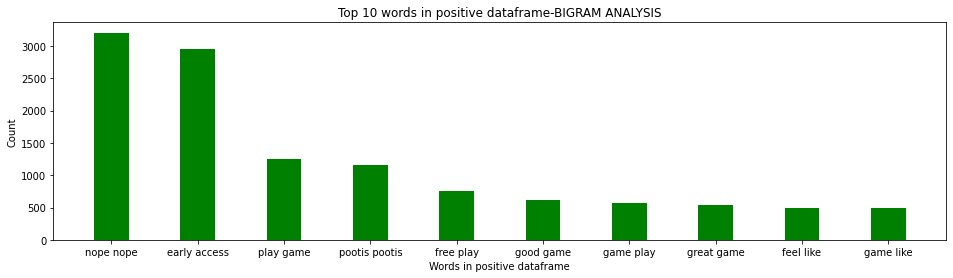

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(pd1bigram,pd2bigram, color ='green',width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-BIGRAM ANALYSIS")
#plt.savefig("positive-bigram.png")
plt.show()


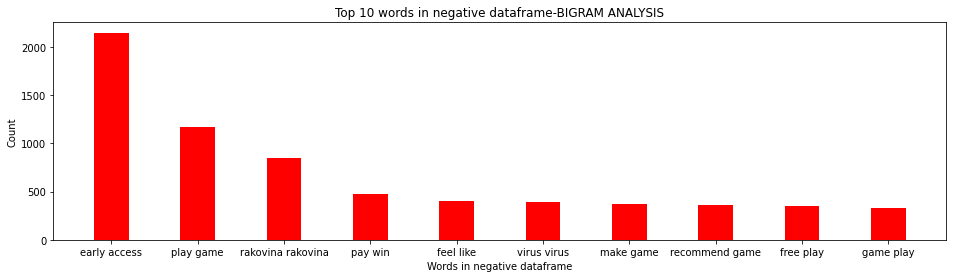

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(nd1bigram,nd2bigram, color ='red',
        width = 0.4)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-BIGRAM ANALYSIS")
#plt.savefig("negative-bigram.png")
plt.show()

In [ ]:
#Check out plotly express's bubble chart
embed_df = pd.concat([df_positive2, df_negative2])
embed_df.columns = ['bigram', 'count', 'rating']
#embed_df = sorted(embed_df,key=lambda x:x[1],reverse=True)
#embed_df=embed_df.sort_values('bigram',ascending=True)

embed_df['count_pos']=embed_df['count']*embed_df['rating']
embed_df['count_neg']=embed_df['count']*(1-embed_df['rating'])

#embed_df2 = embed_df.groupby('bigram')['count_pos', 'count_neg'].sum()
embed_df2 = embed_df.groupby(['bigram']).agg({'count': "count", 'rating': "sum",'count_pos': 'sum', 'count_neg':'sum'})
embed_df2['count_tot']=embed_df2['count_pos']+embed_df2['count_neg']
embed_df2['positivity']=embed_df2['count_pos']/embed_df2['count_tot']
embed_df2=embed_df2.sort_values('count_tot',ascending=False)
#display(embed_df2)

embed_df2=embed_df2.reset_index()
fig = px.scatter(embed_df2[:10], x='count_pos', y='count_neg', hover_name='bigram', text='bigram', size='count_tot', color='positivity', size_max=45
                 , template='plotly_white', title='Top 10 Bigram positivity and frequency', labels={'words': 'Avg. Length<BR>(words)'}
                 , color_continuous_scale=px.colors.sequential.Sunsetdark)
fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
fig.update_xaxes(visible=True)
fig.update_yaxes(visible=True)
fig.show()



In [ ]:
#Save figure to output
#uncomment following if want to re-export
# import os
# #conda install -c conda-forge python-kaleido
# ! pip install -U kaleido
# if not os.path.exists("images"):
#     os.mkdir("images")
#     fig.write_image("images/bigram_bubble.png")

# Metrics
Different metrics inform our analysis in their own way.  There are some NLP projects that prioritize log-loss, AUC, f1, accuracy, and others. 

Part of our choice depends on the following question - should this analysis investigate or explore the level of nuance of a review?  Or should the end goal be simply to predict positivity/negativity well?  

- Log-loss is a highly useful metric for evaluating probability.  In this case, our models will be estimating a probability of being a positive review along the way (or, arguably, the level of positive sentiment in the review), so this will be a contender.  This measure will continue to give feedback throughout tuning.

- AUC (and ROC curves) measure the ability for a model to separate labels correctly into two distinct categories.  That is included in our goal, so this is also a contender metric that we will look at.  ROC curves can serve as a useful visualization for comparison of different models.  They are also useful when there is a mostly-even distribution in labels (which is what we have).  If they were not even, a precision-recall curve would be more useful.

- f1 is a blend of recall and precision, and is worth consideration.

- Accuracy will have less "gray area," and won't really be able to consider the nuance (e.g. a lukewarm review might give .6 positivity), but if our priority at the end of the line is to correctly predict positive/negative (and ignore the degree of each), then this could be considered.  This measure will likely give less feedback during tuning, as once a prediction meets the right label, it is considered good enough.  Accuracy and f1 have better business interpretability.

So, in the end, we will optimize our models on log-loss, but report f1 and accuracy for better business interpretability.





In [ ]:
def score_report(ytrue, preds, bin_preds=None):
    #create score report for model predictions including log-loss, AUC/ROC, F1, accuracy
    try:
        if bin_preds == None :
          bin_preds = round(preds)
    except:
        pass
    log_l = log_loss(ytrue, preds)
    print ("Model Log-loss: %0.3f " % log_l)
    f1=f1_score(ytrue, bin_preds)
    acc=accuracy_score(ytrue, bin_preds)
    try:
        f1=f1_score(ytrue, bin_preds)
        acc=accuracy_score(ytrue, bin_preds)
        
        print ("Model F1 score: %0.3f " % f1)
        print ("Model Accuracy score: %0.3f " % acc)
    except:
        f1=None
        acc=None
        print ("Model F1 score: not applicable")
        print ("Model Accuracy score: not applicable")
    #auc/roc
    majority = Counter(ytrue).most_common(1)[0][0]
    ns_probs = [majority for _ in range(len(ytrue))]
    ns_auc = roc_auc_score(ytrue, ns_probs)
    m_auc = roc_auc_score(ytrue, preds[:,1])#predictions
    print('Naive ROC AUC=%.3f' % (ns_auc))
    print('Model ROC AUC=%.3f' % (m_auc))
    ns_fpr, ns_tpr, _ = roc_curve(ytrue, ns_probs)
    m_fpr, m_tpr, _ = roc_curve(ytrue, preds[:,1])
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(m_fpr, m_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    return [log_l, f1, acc, m_auc]

In [ ]:
# record model scores:
model_scores=[]

In [ ]:
# store models that perform well:
models={}
model_test_scores = []

# Starting Models
- TF-IDF
- Logistic Regression

# On the raw user reviews

In [ ]:
xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split(splits[0])
suffix=0

In [ ]:
print(xtrain.shape), print(ytrain.shape)
print(xvalid.shape), print(yvalid.shape)
print(xtest.shape), print(ytest.shape)
ytrain

(13994,)
(13994,)
(1750,)
(1750,)
(1750,)
(1750,)


array([1, 1, 0, ..., 0, 1, 1])

# Creating Term Frequency-Inverse Document Frequency (TF-IDF) set

In [ ]:
#First, try a tfidfVectorizer with default settings

tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (one source calls this semi-supervised learning, but I believe it is more to be just ensuring the TF-IDF has the 
#proper columns to include the test set as well as the training set.  I.e. here "fit" just means to 	
#Learn vocabulary and idf from training set.)
tfv.fit(list(xtrain) + list(xvalid) + list(xtest))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

Scores for simple Logistic Regression on default TFIDF on _raw data.
Model Log-loss: 0.349 
Model F1 score: 0.892 
Model Accuracy score: 0.874 
Naive ROC AUC=0.500
Model ROC AUC=0.942


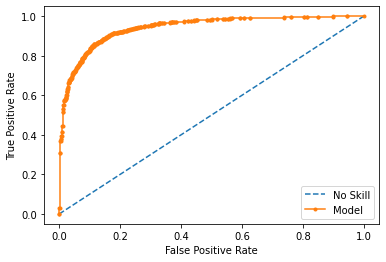

In [ ]:
# Fit a simple Logistic Regression on TF-IDF
suffix=0
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))
mname='Scores for simple Logistic Regression on default TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.

models[mname] = clf
finalModel_1=clf

Model Log-loss: 0.363 
Model F1 score: 0.874 
Model Accuracy score: 0.853 
Naive ROC AUC=0.500
Model ROC AUC=0.932


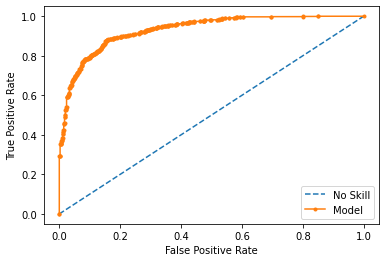

In [ ]:
#Upon investigation, we see that this model is a keeper.  We will eval its test scores now
predictions = clf.predict_proba(xtest_tfv)
bin_preds = clf.predict(xtest_tfv)
scores = [score_report(ytest, predictions, bin_preds)]
model_test_scores.append([mname, scores])

In [ ]:
display(predictions)
display(bin_preds)

array([[0.78482301, 0.21517699],
       [0.57444052, 0.42555948],
       [0.63345271, 0.36654729],
       ...,
       [0.70717923, 0.29282077],
       [0.08922625, 0.91077375],
       [0.07654502, 0.92345498]])

array([0, 0, 0, ..., 0, 1, 1])

Scores for simple Logistic Regression on common parameters-TFIDF on _raw data.
Model Log-loss: 0.381 
Model F1 score: 0.880 
Model Accuracy score: 0.858 
Naive ROC AUC=0.500
Model ROC AUC=0.939


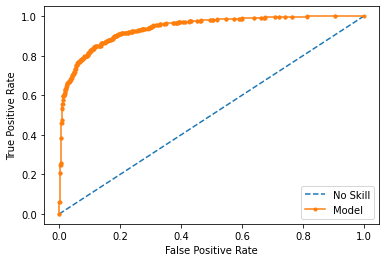

In [ ]:
#Raw plus
suffix=0
xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split(splits[suffix])

# Following features are common starting points and work well in most cases.
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

#tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets 
tfv.fit(list(xtrain) + list(xvalid), list(xtest))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

# Fit a simple Logistic Regression on TF-IDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))


mname='Scores for simple Logistic Regression on common parameters-TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.


WARNING: If you rerun the cells below with SINGLE_SOURCE set to True, the score reports will be removed (the notebook is saved with them visible)

# On the cleaned reviews

Scores for simple Logistic Regression on common parameters-TFIDF on _cln data.
Model Log-loss: 0.395 
Model F1 score: 0.875 
Model Accuracy score: 0.853 
Naive ROC AUC=0.500
Model ROC AUC=0.932


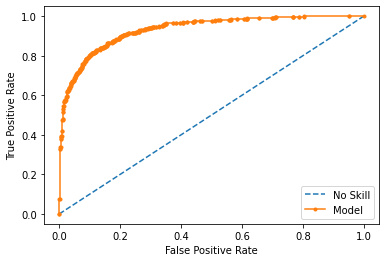

In [ ]:
if not SINGLE_SOURCE:
    suffix=1
    xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split(splits[suffix])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets 
    tfv.fit(list(xtrain) + list(xvalid) + list(xtest))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)
    xtest_tfv = tfv.transform(xtest)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))
    
   
    mname='Scores for simple Logistic Regression on common parameters-TFIDF on {} data.'.format(splits[suffix])
    print(mname)
    scores = [score_report(yvalid, predictions, bin_preds)]
    model_scores.append([mname, scores])
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


# On the lemmatized reviews

Scores for simple Logistic Regression on common parameters-TFIDF on _lem data.
Model Log-loss: 0.402 
Model F1 score: 0.874 
Model Accuracy score: 0.851 
Naive ROC AUC=0.500
Model ROC AUC=0.925


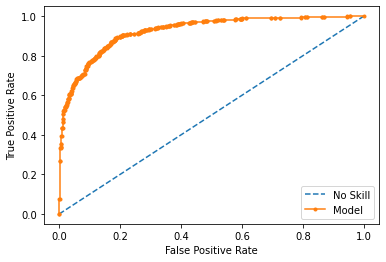

In [ ]:
if not SINGLE_SOURCE:
    suffix=2
    xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split(splits[suffix])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets 
    tfv.fit(list(xtrain) + list(xvalid)+list(xtest))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)
    xtest_tfv = tfv.transform(xtest)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

    mname='Scores for simple Logistic Regression on common parameters-TFIDF on {} data.'.format(splits[suffix])
    print(mname)
    scores = [score_report(yvalid, predictions, bin_preds)]
    model_scores.append([mname, scores])
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


# On the stemmed reviews

Scores for simple Logistic Regression on common parameters-TFIDF on _stm data.
Model Log-loss: 0.397 
Model F1 score: 0.875 
Model Accuracy score: 0.851 
Naive ROC AUC=0.500
Model ROC AUC=0.931


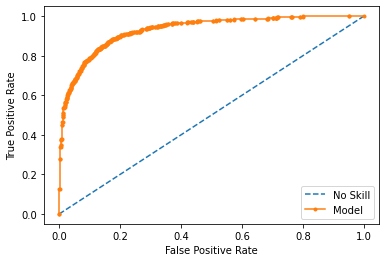

In [ ]:
if not SINGLE_SOURCE:
    suffix=3
    xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split(splits[suffix])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets
    tfv.fit(list(xtrain) + list(xvalid)+list(xtest))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)
    xtest_tfv = tfv.transform(xtest)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

    mname='Scores for simple Logistic Regression on common parameters-TFIDF on {} data.'.format(splits[suffix])
    print(mname)
    scores = [score_report(yvalid, predictions, bin_preds)]
    model_scores.append([mname, scores])
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


# Select which type of reviews

Somewhat unexpectedly, the built-in processing in TfidfVectorizer works best on logistic regression. Whether stemming/lemmatization underperform because they aren't capturing vernacular is unclear, but we will proceed with it (rerunning that cell below to re-initialize all its variables).  


In [ ]:
model_scores

[['Scores for simple Logistic Regression on default TFIDF on _raw data.',
  [[0.34854924413950905,
    0.8919315403422983,
    0.8737142857142857,
    0.9418134882735857]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _raw data.',
  [[0.3808601207964811,
    0.8804243008678881,
    0.8582857142857143,
    0.9389709633548721]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _cln data.',
  [[0.3946347841295105,
    0.8754826254826255,
    0.8525714285714285,
    0.931732781345364]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _lem data.',
  [[0.4019982510939392,
    0.874095513748191,
    0.8508571428571429,
    0.9249701295120422]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _stm data.',
  [[0.39728276580383654,
    0.8747591522157997,
    0.8514285714285714,
    0.9308989385154135]]]]

However, because lemmatized data tend to have better performance in the long run, we will proceed with those.  

In [ ]:
#Reinstantiate desired set
#going with Lemmatized data - since it will reduce to real, dictionary-valid words, not just stems.
suffix=2
xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split(splits[suffix])

# Following features are common starting points and work well in most cases.
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

#tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets 
tfv.fit(list(xtrain) + list(xvalid)+list(xtest))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

# Fit a simple Logistic Regression on TF-IDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

# mname='Scores for simple Logistic Regression on TFIDF on {} data.'.format(splits[suffix])
# print(mname)
# scores = [score_report(yvalid, predictions, bin_preds)]
#model_scores.append([mname, scores])
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.


# Word Counts - CountVectorizer

Instead of using TF-IDF, we can also use word counts as features. Here we will use CountVectorizer from scikit-learn.

In [ ]:
suffix=2
xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split(splits[suffix])

# ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
#             ngram_range=(1, 3), stop_words = 'english')

ctv = CountVectorizer()

# Fitting Count Vectorizer to both training and test sets
ctv.fit(list(xtrain) + list(xvalid) + list(xtest))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)
xtest_ctv = ctv.transform(xtest)

In [ ]:
#checking out an arbitrary entry of that ctv
xtrain_ctv[1,2]

0

Scores for simple Logistic Regression on counts on _lem data.
Model Log-loss: 0.458 
Model F1 score: 0.856 
Model Accuracy score: 0.835 
Naive ROC AUC=0.500
Model ROC AUC=0.910


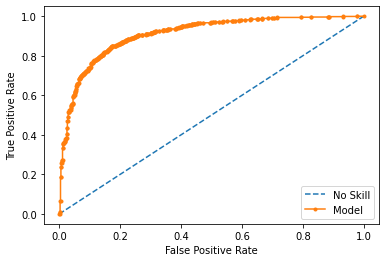

In [ ]:
# Fit a simple Logistic Regression on those Counts
clf = LogisticRegression(C=1.0, max_iter=500,)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
bin_preds = clf.predict(xvalid_ctv)

mname='Scores for simple Logistic Regression on counts on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Scores for simple Naive Bayes on TF-IDF on _lem data.
Model Log-loss: 0.424 
Model F1 score: 0.855 
Model Accuracy score: 0.817 
Naive ROC AUC=0.500
Model ROC AUC=0.920


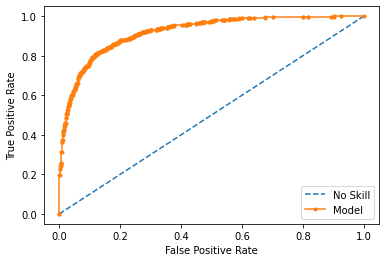

In [ ]:
# Fit a simple Naive Bayes on TF-IDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)


mname='Scores for simple Naive Bayes on TF-IDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

What happens when we use this model on counts data instead?

Scores for simple Naive Bayes on Counts on _lem data.
Model Log-loss: 0.752 
Model F1 score: 0.852 
Model Accuracy score: 0.834 
Naive ROC AUC=0.500
Model ROC AUC=0.902


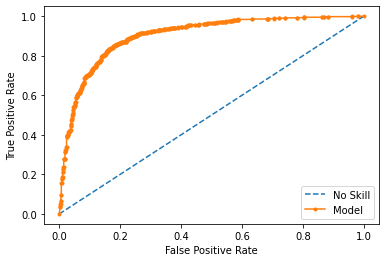

In [ ]:
# Fit a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
bin_preds = clf.predict(xvalid_ctv)



mname='Scores for simple Naive Bayes on Counts on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])
models[mname] = clf
finalModel_2=clf

Model Log-loss: 0.924 
Model F1 score: 0.842 
Model Accuracy score: 0.821 
Naive ROC AUC=0.500
Model ROC AUC=0.884


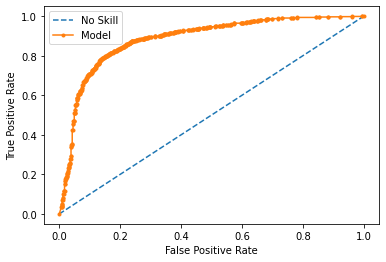

In [ ]:
#Upon investigation, we see that this model is a keeper.  We will eval its test scores now
predictions = clf.predict_proba(xtest_ctv)
bin_preds = clf.predict(xtest_ctv)
scores = [score_report(ytest, predictions, bin_preds)]
model_test_scores.append([mname, scores])

NB on counts did not improve but is still a contender

One more classic algorithm is SVMs. 

In order to improve performance on time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM.

Also, it is better to standardize the data before applying SVMs.

In [ ]:
# Apply SVD, with 120 components. 120-200 components are widely considered sufficient for SVM.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)
xtest_svd_scl = scl.transform(xtest_svd)

Now time to fit the SVM.  This can take a while!

Scores for simple SVM on scaled SVD on TF-IDF on _lem data.
Model Log-loss: 0.374 
Model F1 score: 0.855 
Model Accuracy score: 0.832 
Naive ROC AUC=0.500
Model ROC AUC=0.912


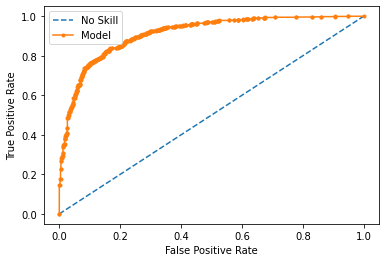

In [ ]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we want probabilities in addition to the 0/1 scores
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)
bin_preds = clf.predict(xvalid_svd_scl)



mname='Scores for simple SVM on scaled SVD on TF-IDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

models[mname] = clf
finalModel_3=clf

Model Log-loss: 0.394 
Model F1 score: 0.845 
Model Accuracy score: 0.818 
Naive ROC AUC=0.500
Model ROC AUC=0.903


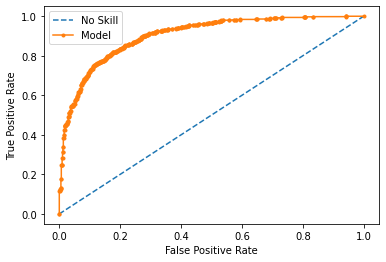

In [ ]:
#Upon investigation, we see that this model is a keeper.  We will eval its test scores now
predictions = clf.predict_proba(xtest_svd_scl)
bin_preds = clf.predict(xtest_svd_scl)
scores = [score_report(ytest, predictions, bin_preds)]
model_test_scores.append([mname, scores])

This is even better loss and good f1/acc.

That performed pretty well on logloss.  Neat!  

Of course, we couldn't stop without trying XGBoost!

Scores for simple XGBoost on TFIDF on _lem data.
Model Log-loss: 0.422 
Model F1 score: 0.838 
Model Accuracy score: 0.807 
Naive ROC AUC=0.500
Model ROC AUC=0.890


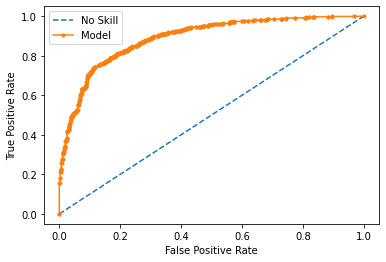

In [ ]:
# Fit a basic xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())
bin_preds = clf.predict(xvalid_tfv.tocsc())


mname='Scores for simple XGBoost on TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Strangely, XGBoost didn't do as well on TF-IDF features as logistic regression.

Scores for simple XGBoost on TF-IDF SVD features on _lem data.
Model Log-loss: 0.444 
Model F1 score: 0.784 
Model Accuracy score: 0.749 
Naive ROC AUC=0.500
Model ROC AUC=0.884


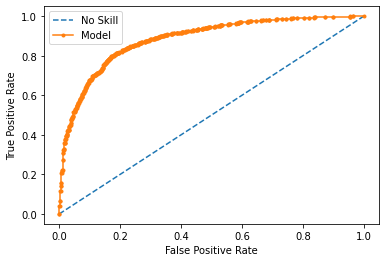

In [ ]:
# Fitting a simple xgboost on tf-idf svd features with default parameters
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)
bin_preds = clf.predict(xvalid_svd_scl)

mname='Scores for simple XGBoost on TF-IDF SVD features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Scores for simple XGBoost on TF-IDF SVD (with common hyperparams) features on _lem data.
Model Log-loss: 0.392 
Model F1 score: 0.844 
Model Accuracy score: 0.819 
Naive ROC AUC=0.500
Model ROC AUC=0.903


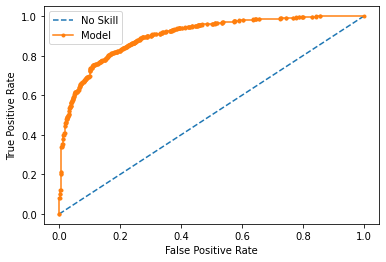

In [ ]:
# Fit a basic xgboost on more common hyperparams for tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)
bin_preds = clf.predict(xvalid_svd)


mname='Scores for simple XGBoost on TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

On TF-IDF SVD unscaled features, XGBoost does not improve.  

What about on scaled features?

Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _lem data.
Model Log-loss: 0.392 
Model F1 score: 0.844 
Model Accuracy score: 0.819 
Naive ROC AUC=0.500
Model ROC AUC=0.903


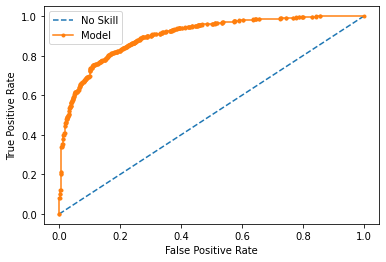

In [ ]:
# Fit a basic xgboost on SCALED tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)
bin_preds = clf.predict(xvalid_svd_scl)

mname='Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])
models[mname] = clf
finalModel_4=clf

Model Log-loss: 0.426 
Model F1 score: 0.837 
Model Accuracy score: 0.809 
Naive ROC AUC=0.500
Model ROC AUC=0.886


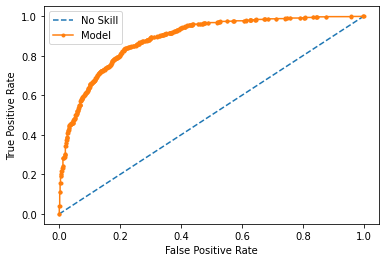

In [ ]:
#Upon investigation, we see that this model is a keeper.  We will eval its test scores now
predictions = clf.predict_proba(xtest_svd_scl)
bin_preds = clf.predict(xtest_svd_scl)
scores = [score_report(ytest, predictions, bin_preds)]
model_test_scores.append([mname, scores])

So, on Scaled TF-IDF SVD features, XGboost does very similarly.  

But wait!  We haven't done any tuning of hyperparameters yet.

# Improve all those models with some grid search optimization  
First, we can define a scoring metric for automation.  Log-loss will suffice for now, as it was represented the other metrics and seemed to be more sensitive.

In [ ]:
basic_scorer = metrics.make_scorer(log_loss, greater_is_better=False, needs_proba=True)

Since we applied svd and scaling to to TF-IDF vectors, this seems like it has potential for a pipeline approach, in order to make the gridsearching across the svd and logistic regression all in one step.

In [ ]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize a standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here.
lr_model = LogisticRegression()

# Create the Logistic Regression pipeline 
clf_lr = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

#Set up the parameter grid
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}
       
                         
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, #iid=True, 
                                  refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))              
    


Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best score: -0.429
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l1'
	svd__n_components: 120


Scores for gridsearched scaled svd on TFIDF on _lem data.
Model Log-loss: 0.422 
Model F1 score: 0.838 
Model Accuracy score: 0.807 
Naive ROC AUC=0.500
Model ROC AUC=0.890


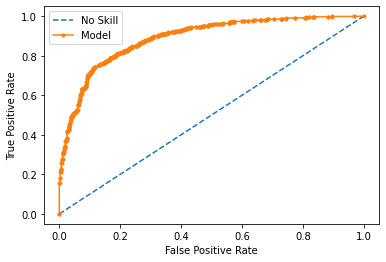

In [ ]:
predictions = model.predict_proba(xvalid_tfv)
bin_preds = model.predict(xvalid_tfv)

mname='Scores for gridsearched scaled svd on TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])


## Now Gridsearch on Naive Bayes

In [ ]:
#Now try optimizing Naive Bayes
mname='Scores for gridsearched scaled TF-IDF SVD Naive Bayes on selected data.'
print(mname)

nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.1]}#[0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, #iid=True, 
                                refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
#model2 = model


Scores for gridsearched scaled TF-IDF SVD Naive Bayes on selected data.
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best score: -0.388
Best parameters set:
	nb__alpha: 0.1


Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _lem data.
Model Log-loss: 0.367 
Model F1 score: 0.859 
Model Accuracy score: 0.838 
Naive ROC AUC=0.500
Model ROC AUC=0.916


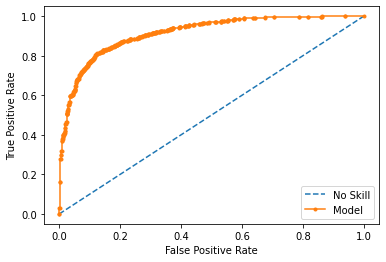

In [ ]:
### testing it

clf = MultinomialNB(alpha=0.1)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)

mname='Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

model2 = model

# Pretrained Models

# GloVe vectors from here:
http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014.   
GloVe: Global Vectors for Word Representation. 

In [ ]:
# #GloVe Set-up - #moved to top
# # 0) Acquire glove zipped file and put on google drive to use with Colab

# # 1) unzip
# ##only run the following lines once!
# from google.colab import drive
# drive.mount('/content/gdrive')
# #### !unzip gdrive/My\ Drive/DataSciUploads/GloVe/glove.840B.300d.zip


# # 2) make file available
# #GLOVE_PATH = '/content/gdrive/MyDrive/DataSciUploads/GloVe/glove.840B.300d.txt'
# GLOVE_PATH = '/content/gdrive/MyDrive/DataSciUploads/GloVe/glove.6B.300d.txt'


In [ ]:
# load the GloVe vectors in a dictionary:
##local path only - superceded by colab-google-drive method in cell above
##GLOVE_PATH = 'E:\Downloads\glove.840B.300d/glove.840B.300d.txt'
# class IncrementalDecoder(codecs.IncrementalDecoder):
#     def decode(self, input, final=False):
#         return codecs.charmap_decode(input,self.errors,decoding_table)[0]


'''with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector'''
'''with open(file, 'rb') as fopen:
        q = fopen.read()
        print(q.decode('latin-1')) #or any encoding which is suitable here.
'''
'''for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
'''
embeddings_index = {}
with open(GLOVE_PATH, 'rb') as f:
    for line in tqdm(f):
        #print(line)
        parts = line.split()
        word = parts[0].decode("utf-8-sig")
        try:
            coefs = np.asarray(parts[1:], dtype=np.float32)
        except BaseException as err:
            print(err)
            print(parts[0:10])
        embeddings_index[word] = coefs
    #f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:21, 18845.49it/s]

Found 400000 word vectors.


In [ ]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
#ensure we are working with desired data
suffix=2
xtrain, xvalid, ytrain, yvalid, xtest, ytest = select_split(splits[suffix])

In [ ]:
#original, non-looped
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]
xtest_glove = [sent2vec(x) for x in tqdm(xtest)]

100%|██████████| 1750/1750 [00:00<00:00, 1798.05it/s]


In [ ]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
xtest_glove = np.array(xtest_glove)

Check the performance of xgboost on glove features:`

Scores for simple XGBoost on glove features on _lem data.
Model Log-loss: 0.493 
Model F1 score: 0.793 
Model Accuracy score: 0.757 
Naive ROC AUC=0.500
Model ROC AUC=0.842


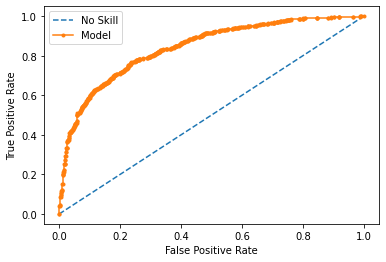

In [ ]:
# Fit a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10)#, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)
bin_preds = clf.predict(xvalid_glove)


# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

mname='Scores for simple XGBoost on glove features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Scores for slightly more tuned XGBoost on glove features on _lem data.
Model Log-loss: 0.472 
Model F1 score: 0.817 
Model Accuracy score: 0.786 
Naive ROC AUC=0.500
Model ROC AUC=0.866


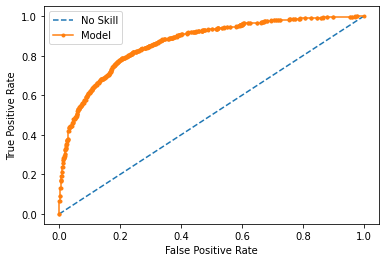

In [ ]:
# Fit a slightly less simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1) #silent=False
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)
bin_preds = clf.predict(xvalid_glove)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

mname='Scores for slightly more tuned XGBoost on glove features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

In [ ]:
# a tuning of parameters can improve xgboost score on GloVe features!
#but we can tune even more to improve further

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best score: -0.470
Best parameters set:
	xgb__colsample_bytree: 0.5
	xgb__gamma: 0.1
	xgb__learning_rate: 0.1
	xgb__max_depth: 6
	xgb__min_child_weight: 3
Scores for gridsearched XGBoost on glove features on _raw data.
Model Log-loss: 0.471 
Model F1 score: 0.804 
Model Accuracy score: 0.770 
Naive ROC AUC=0.500
Model ROC AUC=0.853


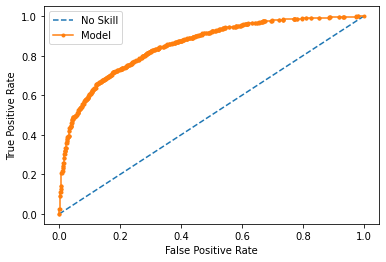

In [ ]:
#Now try optimizing XGBoost on GloVe 

xgb_model = xgb.XGBClassifier()

# Create the pipeline 
clf = pipeline.Pipeline([('xgb', xgb_model)])

# parameter grid

param_grid = {"xgb__learning_rate"    : [0.10], # previously [0.05, 0.10, 0.20] ,
 "xgb__max_depth"        : [ 6], #previously [6, 8],
 "xgb__min_child_weight" : [ 3],
 "xgb__gamma"            : [0.1], #prev [0.1, 0.2 , 0.4 ],
 "xgb__colsample_bytree" : [0.5] # prev [ 0.3, 0.5, 0.7] 
}                

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, #iid=True, 
                                refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_glove, ytrain) 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

###probably need to set features
predictions = model.predict_proba(xvalid_glove)
bin_preds = model.predict(xvalid_glove)

mname='Scores for gridsearched XGBoost on glove features on {} data.'.format(splits[0])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])


This is somewhat surprisingly unimpressive.  

# Deep Learning   
Dense network, RNN, LSTM and GRU

In [ ]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)
xtest_glove_scl = scl.transform(xtest_glove)

In [ ]:
display(xtrain_glove_scl.shape)
display(xvalid_glove_scl.shape)
display(xtest_glove_scl.shape)

(13994, 300)

(1750, 300)

(1750, 300)

In [ ]:
ytrain.shape

(13994,)

In [ ]:
ytrain

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
yvalid.shape

(1750,)

In [ ]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)
ytest_enc = np_utils.to_categorical(ytest)

In [ ]:
display(ytrain_enc.shape)
display(yvalid_enc.shape)
display(ytest_enc.shape)
ytrain_enc

(13994, 2)

(1750, 2)

(1750, 2)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
# create a 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')



Epoch 1/8
219/219 [==============================] - 4s 4ms/step - loss: 0.5423 - val_loss: 0.4653
Epoch 2/8
219/219 [==============================] - 1s 4ms/step - loss: 0.4395 - val_loss: 0.4569
Epoch 3/8
219/219 [==============================] - 1s 4ms/step - loss: 0.4057 - val_loss: 0.4623
Epoch 4/8
219/219 [==============================] - 1s 4ms/step - loss: 0.3823 - val_loss: 0.4484
Epoch 5/8
219/219 [==============================] - 1s 4ms/step - loss: 0.3564 - val_loss: 0.4561
Epoch 6/8
219/219 [==============================] - 1s 4ms/step - loss: 0.3401 - val_loss: 0.4651
Epoch 7/8
219/219 [==============================] - 1s 4ms/step - loss: 0.3114 - val_loss: 0.4765
Epoch 8/8
55/55 [==============================] - 0s 1ms/step
Scores for 3 layer sequential neural net.
Model Log-loss: 0.744 
Model F1 score: 0.815 
Model Accuracy score: 0.794 
Naive ROC AUC=0.500
Model ROC AUC=0.870


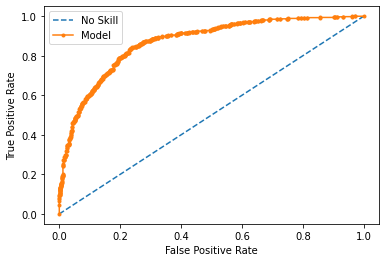

In [ ]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=8, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

#results = model.evaluate(xvalid_glove_scl, yvalid_enc, batch_size=128)
#predictions = model.predict_proba(xvalid_glove_scl)
predictions = model.predict(xvalid_glove_scl)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

#results
mname='Scores for 3 layer sequential neural net.'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Note that from here forward, the Deep learning tools are optimizing on loss scores (by default, sparse categorical cross entropy which is the same as log-loss for this scenario).  We will proceed by comparing loss scores from here out.  However, we will collect acc/f1/AUC for business reporting.

So we can see that past epoch 4, we are overtraining.  Still, this is very quick and does rather well.  Let's tune the model architecture a bit and try again.

In [ ]:
# create a 8 layer sequential neural net with .3-.5 dropout
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(800, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

Epoch 1/10
219/219 [==============================] - 4s 8ms/step - loss: 0.7334 - val_loss: 0.5308
Epoch 2/10
219/219 [==============================] - 2s 7ms/step - loss: 0.5425 - val_loss: 0.4952
Epoch 3/10
219/219 [==============================] - 2s 7ms/step - loss: 0.4826 - val_loss: 0.4687
Epoch 4/10
219/219 [==============================] - 2s 7ms/step - loss: 0.4516 - val_loss: 0.4632
Epoch 5/10
219/219 [==============================] - 2s 7ms/step - loss: 0.4307 - val_loss: 0.4610
Epoch 6/10
219/219 [==============================] - 2s 7ms/step - loss: 0.4107 - val_loss: 0.4586
Epoch 7/10
219/219 [==============================] - 2s 7ms/step - loss: 0.3981 - val_loss: 0.4626
Epoch 8/10
219/219 [==============================] - 2s 8ms/step - loss: 0.3749 - val_loss: 0.4711
Epoch 9/10
219/219 [==============================] - 2s 8ms/step - loss: 0.3637 - val_loss: 0.4602
Epoch 10/10
55/55 [==============================] - 0s 2ms/step
Scores for 8 layer sequential neura

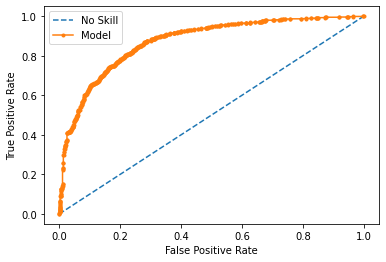

In [ ]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

mname='Scores for 8 layer sequential neural net with .3-.5 dropout.'

# bin_preds = model.predict(xvalid_glove_scl)
# #predictions = model.predict_proba(xvalid_glove_scl)
# predictions=bin_preds

predictions = model.predict(xvalid_glove_scl)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

#results
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/17
219/219 [==============================] - 4s 8ms/step - loss: 0.7968 - val_loss: 0.6696
Epoch 2/17
219/219 [==============================] - 2s 7ms/step - loss: 0.6867 - val_loss: 0.5356
Epoch 3/17
219/219 [==============================] - 2s 7ms/step - loss: 0.5774 - val_loss: 0.4712
Epoch 4/17
219/219 [==============================] - 2s 7ms/step - loss: 0.5210 - val_loss: 0.4622
Epoch 5/17
219/219 [==============================] - 2s 7ms/step - loss: 0.4933 - val_loss: 0.4524
Epoch 6/17
219/219 [==============================] - 2s 7ms/step - loss: 0.4801 - val_loss: 0.4483
Epoch 7/17
219/219 [==============================] - 2s 7ms/step - loss: 0.4617 - val_loss: 0.4465
Epoch 8/17
219/219 [==============================] - 2s 7ms/step - loss: 0.4541 - val_loss: 0.4488
Epoch 9/17
219/219 [==============================] - 2s 7ms/step - loss: 0.4458 - val_loss: 0.4456
Epoch 10/17
219/219 [==============================] - 2s 7ms/step - loss: 0.4375 - val_loss: 0.4449

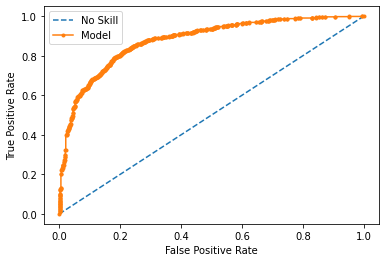

In [ ]:
# testing 8 layer dense neural net with .5 dropout instead of varied
#original, non-looped
# create a 8 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(800, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=17, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

mname='Scores for 8 layer dense neural net with .5 dropout'
#predictions = model.predict_proba(xvalid_glove_scl)
# bin_preds = model.predict(xvalid_glove_scl)
# predictions = bin_preds

predictions = model.predict(xvalid_glove_scl)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]


print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])



So, we can see after just a little tuning on dense deep neural nets, with some dropout, we can get better results than xgboost.  
Let's proceed into Recurrent Neural Nets (and then into LSTMs and GRUs)

# RNNs

In order to work with these, we should tokenize the text data.

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid)+list(xtest))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtest_seq = token.texts_to_sequences(xtest)

# zero pad the sequences
#xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
#xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)
word_index = token.word_index

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 72384/72384 [00:00<00:00, 799984.46it/s]


Epoch 1/30
28/28 [==============================] - 3s 73ms/step - loss: 0.6907 - val_loss: 0.5979
Epoch 2/30
28/28 [==============================] - 1s 45ms/step - loss: 0.5971 - val_loss: 0.5684
Epoch 3/30
28/28 [==============================] - 1s 45ms/step - loss: 0.5705 - val_loss: 0.5317
Epoch 4/30
28/28 [==============================] - 1s 46ms/step - loss: 0.5603 - val_loss: 0.5128
Epoch 5/30
28/28 [==============================] - 1s 44ms/step - loss: 0.5505 - val_loss: 0.5466
Epoch 6/30
28/28 [==============================] - 1s 45ms/step - loss: 0.5400 - val_loss: 0.5300
Epoch 7/30
55/55 [==============================] - 0s 6ms/step
basic RNN with glove embeddings and two dense layers - batch size 512
Model Log-loss: 0.522 
Model F1 score: 0.772 
Model Accuracy score: 0.758 
Naive ROC AUC=0.500
Model ROC AUC=0.830


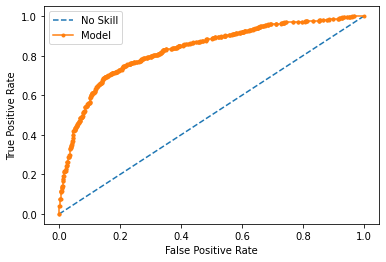

In [ ]:
# A basic RNN with glove embeddings and two dense layers - batch size 512
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(100))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=30, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])
#model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, verbose=1, validation_data=(xvalid_pad, yvalid_enc))


# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='basic RNN with glove embeddings and two dense layers - batch size 512'

print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])


In [ ]:
bin_preds[:10]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 0]

Epoch 1/100
28/28 [==============================] - 3s 55ms/step - loss: 0.6845 - val_loss: 0.5782
Epoch 2/100
28/28 [==============================] - 1s 50ms/step - loss: 0.5952 - val_loss: 0.5403
Epoch 3/100
28/28 [==============================] - 1s 49ms/step - loss: 0.5672 - val_loss: 0.5283
Epoch 4/100
28/28 [==============================] - 1s 49ms/step - loss: 0.5608 - val_loss: 0.5188
Epoch 5/100
28/28 [==============================] - 1s 48ms/step - loss: 0.5479 - val_loss: 0.5265
Epoch 6/100
28/28 [==============================] - 1s 48ms/step - loss: 0.5382 - val_loss: 0.5450
Epoch 7/100
28/28 [==============================] - 1s 47ms/step - loss: 0.5575 - val_loss: 0.5113
Epoch 8/100
28/28 [==============================] - 1s 48ms/step - loss: 0.5565 - val_loss: 0.5159
Epoch 9/100
28/28 [==============================] - 1s 47ms/step - loss: 0.5426 - val_loss: 0.5680
Epoch 10/100
55/55 [==============================] - 0s 6ms/step
basic RNN with glove embeddings an

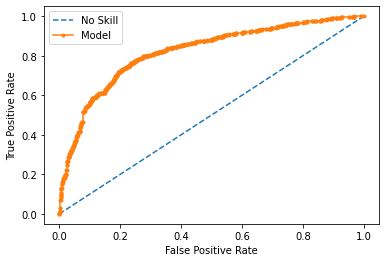

In [ ]:
# A basic RNN with glove embeddings and two dense layers - change batch size to 64 not 512
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(100))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])
#model.fit(xtrain_pad, y=ytrain_enc, batch_size=64, epochs=20, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='basic RNN with glove embeddings and two dense layers - change batch size to 64 not 512'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])


Interesting, reducing the batch size made loss worse.  There were seemingly not enough samples in each batch to settle in on one gradient direction.

# LSTMs


Epoch 1/100
28/28 [==============================] - 9s 246ms/step - loss: 0.6467 - val_loss: 0.5025
Epoch 2/100
28/28 [==============================] - 7s 237ms/step - loss: 0.5564 - val_loss: 0.5052
Epoch 3/100
28/28 [==============================] - 7s 239ms/step - loss: 0.5336 - val_loss: 0.4747
Epoch 4/100
28/28 [==============================] - 7s 240ms/step - loss: 0.5184 - val_loss: 0.4695
Epoch 5/100
28/28 [==============================] - 7s 237ms/step - loss: 0.5096 - val_loss: 0.4837
Epoch 6/100
28/28 [==============================] - 7s 235ms/step - loss: 0.4937 - val_loss: 0.4627
Epoch 7/100
28/28 [==============================] - 7s 239ms/step - loss: 0.4834 - val_loss: 0.4609
Epoch 8/100
28/28 [==============================] - 7s 235ms/step - loss: 0.4737 - val_loss: 0.4457
Epoch 9/100
28/28 [==============================] - 7s 235ms/step - loss: 0.4594 - val_loss: 0.4831
Epoch 10/100
28/28 [==============================] - 7s 235ms/step - loss: 0.4581 - val_lo

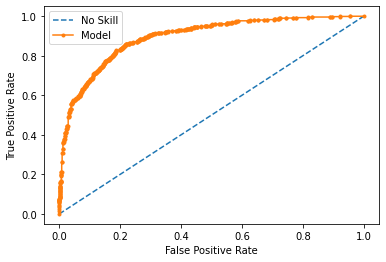

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A simple LSTM with glove embeddings and two dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Note that the dropout above was necessary to avoid overfitting too much.  

Next, let's investigate Bi-directional LSTM.

Epoch 1/50
28/28 [==============================] - 17s 465ms/step - loss: 0.6638 - val_loss: 0.6036
Epoch 2/50
28/28 [==============================] - 13s 448ms/step - loss: 0.5716 - val_loss: 0.4938
Epoch 3/50
28/28 [==============================] - 13s 452ms/step - loss: 0.5298 - val_loss: 0.4761
Epoch 4/50
28/28 [==============================] - 13s 449ms/step - loss: 0.5234 - val_loss: 0.4762
Epoch 5/50
28/28 [==============================] - 12s 446ms/step - loss: 0.4993 - val_loss: 0.4665
Epoch 6/50
28/28 [==============================] - 13s 447ms/step - loss: 0.4915 - val_loss: 0.4620
Epoch 7/50
28/28 [==============================] - 12s 443ms/step - loss: 0.4845 - val_loss: 0.4472
Epoch 8/50
28/28 [==============================] - 13s 459ms/step - loss: 0.4657 - val_loss: 0.4564
Epoch 9/50
28/28 [==============================] - 12s 445ms/step - loss: 0.4725 - val_loss: 0.4698
Epoch 10/50
28/28 [==============================] - 12s 444ms/step - loss: 0.4417 - val_lo

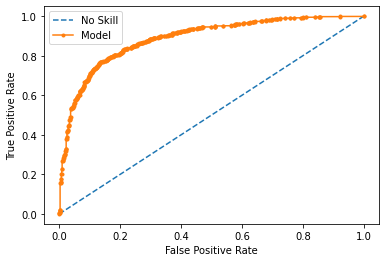

In [ ]:
# A bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A bidirectional LSTM with glove embeddings and two dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/50
28/28 [==============================] - 18s 464ms/step - loss: 0.7073 - val_loss: 0.6865
Epoch 2/50
28/28 [==============================] - 13s 450ms/step - loss: 0.6866 - val_loss: 0.6757
Epoch 3/50
28/28 [==============================] - 13s 448ms/step - loss: 0.6717 - val_loss: 0.6334
Epoch 4/50
28/28 [==============================] - 13s 450ms/step - loss: 0.6087 - val_loss: 0.4981
Epoch 5/50
28/28 [==============================] - 13s 461ms/step - loss: 0.5599 - val_loss: 0.4938
Epoch 6/50
28/28 [==============================] - 13s 449ms/step - loss: 0.5500 - val_loss: 0.4827
Epoch 7/50
28/28 [==============================] - 13s 449ms/step - loss: 0.5229 - val_loss: 0.4765
Epoch 8/50
28/28 [==============================] - 13s 449ms/step - loss: 0.5149 - val_loss: 0.4789
Epoch 9/50
28/28 [==============================] - 13s 450ms/step - loss: 0.4972 - val_loss: 0.4494
Epoch 10/50
28/28 [==============================] - 12s 447ms/step - loss: 0.4873 - val_lo

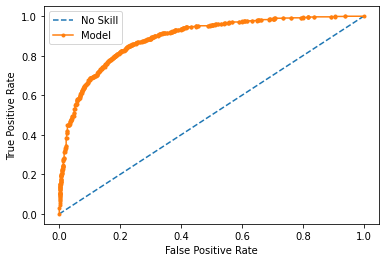

In [ ]:
# A bidirectional LSTM with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A bidirectional LSTM with glove embeddings and three dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/50
28/28 [==============================] - 23s 520ms/step - loss: 0.7184 - val_loss: 0.6879
Epoch 2/50
28/28 [==============================] - 13s 459ms/step - loss: 0.6929 - val_loss: 0.6878
Epoch 3/50
28/28 [==============================] - 13s 462ms/step - loss: 0.6915 - val_loss: 0.6872
Epoch 4/50
28/28 [==============================] - 13s 461ms/step - loss: 0.6877 - val_loss: 0.6862
Epoch 5/50
28/28 [==============================] - 13s 456ms/step - loss: 0.6838 - val_loss: 0.6571
Epoch 6/50
28/28 [==============================] - 13s 460ms/step - loss: 0.6575 - val_loss: 0.6044
Epoch 7/50
28/28 [==============================] - 13s 471ms/step - loss: 0.6335 - val_loss: 0.5868
Epoch 8/50
28/28 [==============================] - 13s 460ms/step - loss: 0.6072 - val_loss: 0.5677
Epoch 9/50
28/28 [==============================] - 13s 453ms/step - loss: 0.5954 - val_loss: 0.5381
Epoch 10/50
28/28 [==============================] - 13s 455ms/step - loss: 0.5567 - val_lo

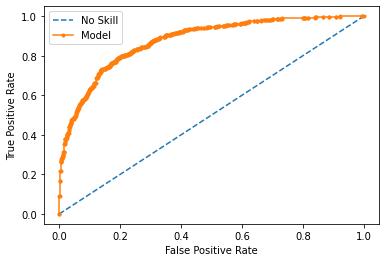

In [ ]:
# A two-layer bidirectional LSTM with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A two-layer bidirectional LSTM with glove embeddings and three dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

LSTM does pretty well, depending on the architecture.  
Next, we try a popular approach, GRU with two layers, on glove embeddings

Epoch 1/100
28/28 [==============================] - 17s 458ms/step - loss: 0.6682 - val_loss: 0.5891
Epoch 2/100
28/28 [==============================] - 12s 433ms/step - loss: 0.5976 - val_loss: 0.4988
Epoch 3/100
28/28 [==============================] - 12s 438ms/step - loss: 0.5418 - val_loss: 0.4759
Epoch 4/100
28/28 [==============================] - 12s 442ms/step - loss: 0.5178 - val_loss: 0.4671
Epoch 5/100
28/28 [==============================] - 12s 436ms/step - loss: 0.5042 - val_loss: 0.5147
Epoch 6/100
28/28 [==============================] - 12s 433ms/step - loss: 0.5017 - val_loss: 0.4743
Epoch 7/100
28/28 [==============================] - 12s 433ms/step - loss: 0.4896 - val_loss: 0.4649
Epoch 8/100
28/28 [==============================] - 12s 431ms/step - loss: 0.4735 - val_loss: 0.4576
Epoch 9/100
28/28 [==============================] - 12s 434ms/step - loss: 0.4614 - val_loss: 0.4376
Epoch 10/100
28/28 [==============================] - 12s 428ms/step - loss: 0.449

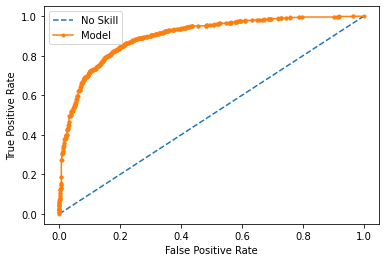

In [ ]:
# Two layer GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A Two layer GRU with glove embeddings and two dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/100
28/28 [==============================] - 17s 445ms/step - loss: 0.7198 - val_loss: 0.6897
Epoch 2/100
28/28 [==============================] - 12s 427ms/step - loss: 0.6904 - val_loss: 0.6872
Epoch 3/100
28/28 [==============================] - 12s 430ms/step - loss: 0.6869 - val_loss: 0.6842
Epoch 4/100
28/28 [==============================] - 12s 427ms/step - loss: 0.6830 - val_loss: 0.6793
Epoch 5/100
28/28 [==============================] - 12s 444ms/step - loss: 0.6759 - val_loss: 0.6531
Epoch 6/100
28/28 [==============================] - 12s 429ms/step - loss: 0.6658 - val_loss: 0.6667
Epoch 7/100
28/28 [==============================] - 12s 431ms/step - loss: 0.6474 - val_loss: 0.6540
Epoch 8/100
28/28 [==============================] - 12s 428ms/step - loss: 0.6254 - val_loss: 0.6041
Epoch 9/100
28/28 [==============================] - 12s 426ms/step - loss: 0.6148 - val_loss: 0.6008
Epoch 10/100
28/28 [==============================] - 12s 433ms/step - loss: 0.613

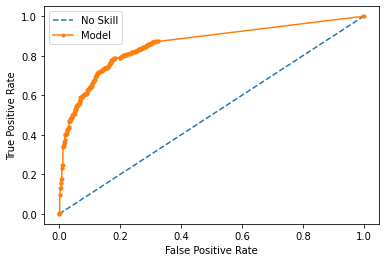

In [ ]:
# Two layer GRU with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A Two layer GRU with glove embeddings and three dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/100
28/28 [==============================] - 34s 880ms/step - loss: 0.6965 - val_loss: 0.6822
Epoch 2/100
28/28 [==============================] - 24s 842ms/step - loss: 0.6779 - val_loss: 0.6243
Epoch 3/100
28/28 [==============================] - 24s 844ms/step - loss: 0.6490 - val_loss: 0.6668
Epoch 4/100
28/28 [==============================] - 24s 854ms/step - loss: 0.6206 - val_loss: 0.5587
Epoch 5/100
28/28 [==============================] - 23s 839ms/step - loss: 0.5948 - val_loss: 0.5562
Epoch 6/100
28/28 [==============================] - 24s 846ms/step - loss: 0.5848 - val_loss: 0.5444
Epoch 7/100
28/28 [==============================] - 24s 846ms/step - loss: 0.5744 - val_loss: 0.5311
Epoch 8/100
28/28 [==============================] - 24s 847ms/step - loss: 0.5622 - val_loss: 0.5438
Epoch 9/100
28/28 [==============================] - 24s 847ms/step - loss: 0.5509 - val_loss: 0.5158
Epoch 10/100
28/28 [==============================] - 23s 839ms/step - loss: 0.544

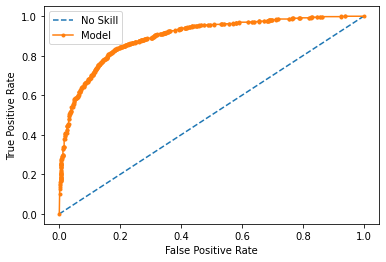

In [ ]:
# 2-layer Bidirectional GRU with glove embeddings and two small dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
#model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A 2-layer Bidirectional GRU with glove embeddings and two small dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])
models[mname] = model
finalModel_5=model

55/55 [==============================] - 5s 95ms/step
Model Log-loss: 0.515 
Model F1 score: 0.809 
Model Accuracy score: 0.797 
Naive ROC AUC=0.500
Model ROC AUC=0.892


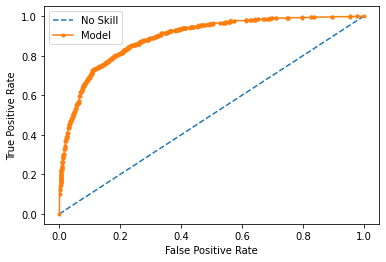

In [ ]:
#Upon investigation, we see that this model is a keeper.  We will eval its test scores now
predictions = model.predict(xtest_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]
scores = [score_report(ytest, predictions, bin_preds)]
model_test_scores.append([mname, scores])

Epoch 1/100
28/28 [==============================] - 33s 869ms/step - loss: 0.6758 - val_loss: 0.5896
Epoch 2/100
28/28 [==============================] - 23s 833ms/step - loss: 0.5836 - val_loss: 0.4856
Epoch 3/100
28/28 [==============================] - 23s 833ms/step - loss: 0.5328 - val_loss: 0.4753
Epoch 4/100
28/28 [==============================] - 23s 839ms/step - loss: 0.5180 - val_loss: 0.4750
Epoch 5/100
28/28 [==============================] - 23s 832ms/step - loss: 0.4998 - val_loss: 0.4609
Epoch 6/100
28/28 [==============================] - 23s 833ms/step - loss: 0.4917 - val_loss: 0.4554
Epoch 7/100
28/28 [==============================] - 23s 840ms/step - loss: 0.4729 - val_loss: 0.4548
Epoch 8/100
28/28 [==============================] - 23s 831ms/step - loss: 0.4664 - val_loss: 0.4684
Epoch 9/100
28/28 [==============================] - 23s 819ms/step - loss: 0.4563 - val_loss: 0.4651
Epoch 10/100
28/28 [==============================] - 23s 820ms/step - loss: 0.433

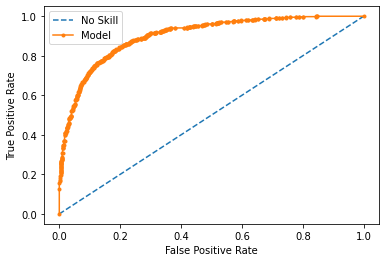

In [ ]:
# Warning; runtime gets pretty long on this !!!
# 2-layer Bidirectional GRU with glove embeddings and two 1024 dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
#model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds

predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A 2-layer Bidirectional GRU with glove embeddings and two 1024 dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

model3 = model

Epoch 1/100
28/28 [==============================] - 16s 422ms/step - loss: 0.6907 - val_loss: 0.6817
Epoch 2/100
28/28 [==============================] - 11s 397ms/step - loss: 0.6689 - val_loss: 0.7611
Epoch 3/100
28/28 [==============================] - 11s 398ms/step - loss: 0.6667 - val_loss: 0.6236
Epoch 4/100
28/28 [==============================] - 11s 401ms/step - loss: 0.6127 - val_loss: 0.5066
Epoch 5/100
28/28 [==============================] - 11s 400ms/step - loss: 0.5718 - val_loss: 0.4709
Epoch 6/100
28/28 [==============================] - 11s 400ms/step - loss: 0.5443 - val_loss: 0.5258
Epoch 7/100
28/28 [==============================] - 11s 410ms/step - loss: 0.5261 - val_loss: 0.4514
Epoch 8/100
28/28 [==============================] - 11s 404ms/step - loss: 0.5036 - val_loss: 0.4515
Epoch 9/100
28/28 [==============================] - 11s 408ms/step - loss: 0.4889 - val_loss: 0.4649
Epoch 10/100
28/28 [==============================] - 11s 402ms/step - loss: 0.485

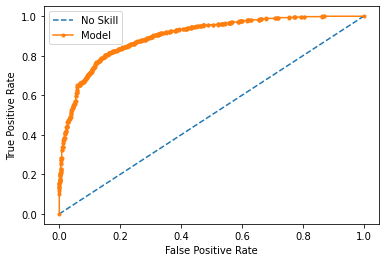

In [ ]:
# single Bidirectional GRU with glove embeddings and four dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

#predictions = model.predict_proba(xvalid_pad)
# bin_preds = model.predict(xvalid_pad)
# predictions = bin_preds
predictions = model.predict(xvalid_pad)
bin_preds = [0 if a[0]>=.5 else 1 for a in predictions]

mname='A single Bidirectional GRU with glove embeddings and four dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

In [ ]:
''' can improve these results even more.  consider stemming/lemmatization? (yes, I went back and revised earlier model) '''

'''Add most commonly occuring words in positive/negative reviews
'''

'NEXT: Put in Apache so we can parallel process\nAdd other metrics\n\nAdd most commonly occuring words in positive/negative reviews\n'

# Pipeline and Pickle

In [ ]:
#Pickle the model dictionary

with open('all_models.pkl', 'wb') as f:
    pickle.dump(models,f)

In [ ]:
with open('all_models.pkl', 'rb') as f:
    unpickled_models = pickle.load(f)

# Model inspection

Top scorers:

'Scores for simple Logistic Regression on default TFIDF on _raw data.'  
Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams)  features on _lem data.'  
'Scores for simple Naive Bayes on Counts on _lem data.',  
'Scores for simple SVM on scaled SVD on TF-IDF on _lem data.',  
'A 2-layer Bidirectional GRU with glove embeddings and two small dense layers'

I have gone back and saved these models for final testing.

In [ ]:
#Number of models:
display(len(model_scores))

32

In [ ]:
model_scores

[['Scores for simple Logistic Regression on default TFIDF on _raw data.',
  [[0.34854924413950905,
    0.8919315403422983,
    0.8737142857142857,
    0.9418134882735857]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _raw data.',
  [[0.3808601207964811,
    0.8804243008678881,
    0.8582857142857143,
    0.9389709633548721]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _cln data.',
  [[0.3946347841295105,
    0.8754826254826255,
    0.8525714285714285,
    0.931732781345364]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _lem data.',
  [[0.4019982510939392,
    0.874095513748191,
    0.8508571428571429,
    0.9249701295120422]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _stm data.',
  [[0.39728276580383654,
    0.8747591522157997,
    0.8514285714285714,
    0.9308989385154135]]],
 ['Scores for simple Logistic Regression on counts on _lem data.',
  [[0.4580012973964002,
    

In [ ]:
def scores_sort(scores, metric='accuracy'):
    ind=0 if metric=='logloss' else (1 if metric=='f1' else(2 if metric=='accuracy' else(3 if metric=='m_auc' else 4)))
    scores.sort(key = lambda x: x[1][0][ind], reverse=True)
    return scores
display(scores_sort(model_scores))

[['Scores for simple Logistic Regression on default TFIDF on _raw data.',
  [[0.34854924413950905,
    0.8919315403422983,
    0.8737142857142857,
    0.9418134882735857]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _raw data.',
  [[0.3808601207964811,
    0.8804243008678881,
    0.8582857142857143,
    0.9389709633548721]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _cln data.',
  [[0.3946347841295105,
    0.8754826254826255,
    0.8525714285714285,
    0.931732781345364]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _stm data.',
  [[0.39728276580383654,
    0.8747591522157997,
    0.8514285714285714,
    0.9308989385154135]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _lem data.',
  [[0.4019982510939392,
    0.874095513748191,
    0.8508571428571429,
    0.9249701295120422]]],
 ['Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _lem da

In [ ]:
#probably not really going to approach it this way - doesn't give the insight we want
def find_top_scores(scores, met='accuracy'):
  metindex=0 if met=='logloss' else (1 if met=='f1' else(2 if met=='accuracy' else(3 if met=='m_auc' else 4)))
  #print('metindex:',metindex)
  #print(scores[0])
  top1=scores[0]
  if scores[1][1][0][metindex]>top1[1][0][metindex]:
    top2=top1
    top1=scores[1]
  else:
    top2=scores[1]
  if scores[2][1][0][metindex]>top2[1][0][metindex]:
    if scores[2][1][0][metindex]>top1[1][0][metindex]:
      #print('case1')
      top3=top2
      top2=top1
      top1=scores[2]
    else:
      #print('case2')
      top3=top2
      top2=scores[2]
  else:
    top3=scores[2]
    #print('case3')

  for s in scores[3:]:
    ##print(s[1][0][metindex])#, print(top3[1][metindex]))
    if s[1][0][metindex]>top3[1][0][metindex]:
      if s[1][0][metindex]>top2[1][0][metindex]:
        if s[1][0][metindex]>top1[1][0][metindex]:
          top3=top2
          top2=top1
          top1=s
        else:
          top3=top2
          top2=s
      else:
        top3=s
    else:
      pass
  return [top1, top2, top3]

display(find_top_scores(model_scores))

[['Scores for simple Logistic Regression on default TFIDF on _raw data.',
  [[0.34854924413950905,
    0.8919315403422983,
    0.8737142857142857,
    0.9418134882735857]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _raw data.',
  [[0.3808601207964811,
    0.8804243008678881,
    0.8582857142857143,
    0.9389709633548721]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _cln data.',
  [[0.3946347841295105,
    0.8754826254826255,
    0.8525714285714285,
    0.931732781345364]]]]

In [ ]:
tfv.get_feature_names()

['aa',
 'aa gun',
 'aaa',
 'aaa game',
 'aaa title',
 'aaand',
 'aand',
 'ab',
 'abandon',
 'abandon game',
 'abdication',
 'aber',
 'abide',
 'abilite',
 'abilitie',
 'ability',
 'ability ability',
 'ability activate',
 'ability actually',
 'ability add',
 'ability allow',
 'ability attack',
 'ability build',
 'ability buy',
 'ability card',
 'ability change',
 'ability character',
 'ability choose',
 'ability class',
 'ability combat',
 'ability craft',
 'ability create',
 'ability damage',
 'ability different',
 'ability enjoy',
 'ability equip',
 'ability example',
 'ability fly',
 'ability gain',
 'ability game',
 'ability hunt',
 'ability hunt animal',
 'ability increase',
 'ability item',
 'ability jump',
 'ability kill',
 'ability kit',
 'ability know',
 'ability learn',
 'ability legendary',
 'ability let',
 'ability level',
 'ability like',
 'ability lot',
 'ability make',
 'ability make game',
 'ability massive',
 'ability mount',
 'ability need',
 'ability passive',
 'abili

# Final Test Set Testing

TESTScores for simple Logistic Regression on default TFIDF on _raw data.
Model Log-loss: 0.402 
Model F1 score: 0.874 
Model Accuracy score: 0.851 
Naive ROC AUC=0.500
Model ROC AUC=0.925


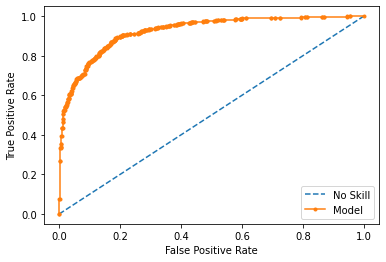

Model Log-loss: 0.402 
Model F1 score: 0.874 
Model Accuracy score: 0.851 
Naive ROC AUC=0.500
Model ROC AUC=0.925


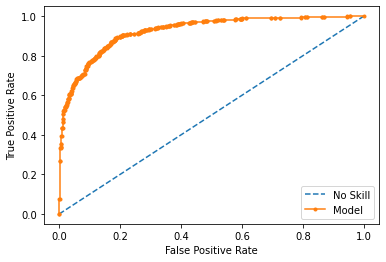

Model Log-loss: 0.410 
Model F1 score: 0.866 
Model Accuracy score: 0.840 
Naive ROC AUC=0.500
Model ROC AUC=0.919


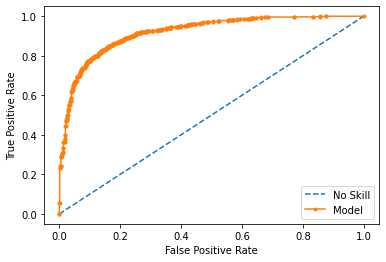

In [ ]:
#model dictionary linkage testing
testmodels={}
suffix=0
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))
mname='TESTScores for simple Logistic Regression on default TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
#model_scores.append([mname, scores])
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.

testmodels[mname] = clf

clf = LogisticRegression(C=1.0)

clfo=testmodels[mname]
predictions = clfo.predict_proba(xvalid_tfv)
bin_preds = clfo.predict(xvalid_tfv)
score_report(yvalid, predictions, bin_preds)
predictions = clfo.predict_proba(xtest_tfv)
bin_preds = clfo.predict(xtest_tfv)
scores = [score_report(ytest, predictions, bin_preds)]

In [ ]:
x=models['Scores for simple Logistic Regression on default TFIDF on _raw data.']
models.items()

dict_items([('Scores for simple Logistic Regression on default TFIDF on _raw data.', LogisticRegression()), ('Scores for simple Naive Bayes on Counts on _lem data.', MultinomialNB()), ('Scores for simple SVM on scaled SVD on TF-IDF on _lem data.', SVC(probability=True)), ('Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _lem data.', XGBClassifier(colsample_bytree=0.8, max_depth=7, n_estimators=200, nthread=10,
              subsample=0.8)), ('A 2-layer Bidirectional GRU with glove embeddings and two small dense layers', <keras.engine.sequential.Sequential object at 0x7f6ddeb848b0>)])

In [ ]:
display(scores_sort(model_test_scores))

[['Scores for simple Logistic Regression on default TFIDF on _raw data.',
  [[0.36336946951137244,
    0.8740234375,
    0.8525714285714285,
    0.9316521942986996]]],
 ['Scores for simple Naive Bayes on Counts on _lem data.',
  [[0.9238690940082548,
    0.8421583459404943,
    0.8211428571428572,
    0.884294983223242]]],
 ['Scores for simple SVM on scaled SVD on TF-IDF on _lem data.',
  [[0.3938270153106708,
    0.8447265625,
    0.8182857142857143,
    0.9031703343763029]]],
 ['Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _lem data.',
  [[0.4264489984077934,
    0.8365949119373777,
    0.8091428571428572,
    0.8859926392723988]]],
 ['A 2-layer Bidirectional GRU with glove embeddings and two small dense layers',
  [[0.515443805499997,
    0.8092423428264374,
    0.7971428571428572,
    0.8917702643121929]]]]

# Test conclusions
Test set accuracy is similar; with Naive Bayes pulling close with LogRegression, but with inferior logloss, AUC, and F1.  


In [ ]:
finacc = []
finlogloss = []
finname=[]
shortModelNames = ['LogReg on basic TF-IDF', 'LogReg on TF-IDF with common hyperparams', 'LogReg on TF-IDF ComHyp w cleaned data', 'LogReg on TF-IDF ComHyp w stemmed data', 
            'LogReg on TF-IDF ComHyp w lemmatized data', 'XGBoost on TF-IDF ComHyp on LemData','LogReg on Counts on LemData','SupportVectorMachine on SVD on TF-IDF on Lem',
            'Naive Bayes on Counts on LemData', 'LSTM on GloVe embeddings w 2 Dense layers']
for model in model_scores[:10]:
  finname.append(model[0])
  finlogloss.append(model[1][0][0])
  finacc.append(model[1][0][2])
print(finname)
print(finlogloss)
print(finacc)


['Scores for simple Logistic Regression on default TFIDF on _raw data.', 'Scores for simple Logistic Regression on common parameters-TFIDF on _raw data.', 'Scores for simple Logistic Regression on common parameters-TFIDF on _cln data.', 'Scores for simple Logistic Regression on common parameters-TFIDF on _stm data.', 'Scores for simple Logistic Regression on common parameters-TFIDF on _lem data.', 'Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _lem data.', 'Scores for simple Logistic Regression on counts on _lem data.', 'Scores for simple Naive Bayes on Counts on _lem data.', 'Scores for simple SVM on scaled SVD on TF-IDF on _lem data.', 'A 2-layer Bidirectional GRU with glove embeddings and two 1024 dense layers']
[0.34854924413950905, 0.3808601207964811, 0.3946347841295105, 0.39728276580383654, 0.4019982510939392, 0.3667058728620909, 0.4580012973964002, 0.7519975996292292, 0.37359349610651643, 0.6273885676801048]
[0.8737142857142857, 0.858285714

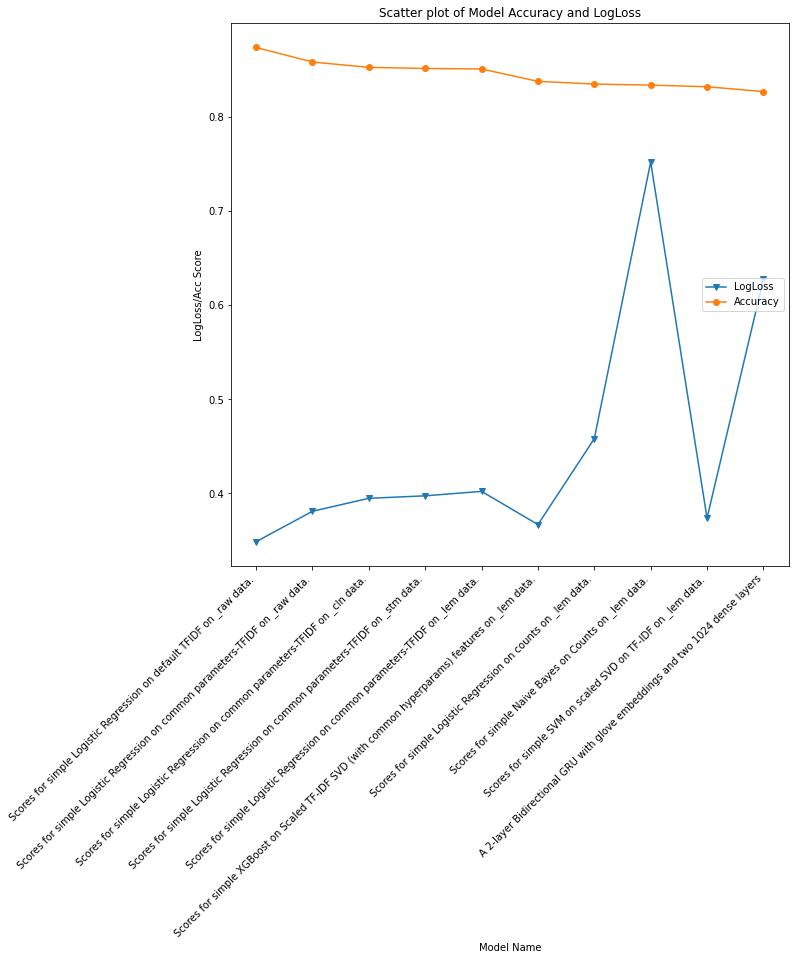

In [ ]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45, ha='right')
plt.plot(finname, finlogloss, marker = 'v', label='Validation Set LogLoss')
plt.plot(finname, finacc, marker= 'o', label = 'Validation Set Accuracy')#, markersize=4
#plt.Line2D(models, testscores, marker='v', )#label='Test Set Accuracy')
plt.title("Scatter plot of Model Accuracy and LogLoss")
plt.xticks(range(0, len(finlogloss)), finname)
plt.xlabel('Model Name')
plt.ylabel('LogLoss/Acc Score')
plt.legend(['LogLoss', 'Accuracy'],loc=5)
plt.show()

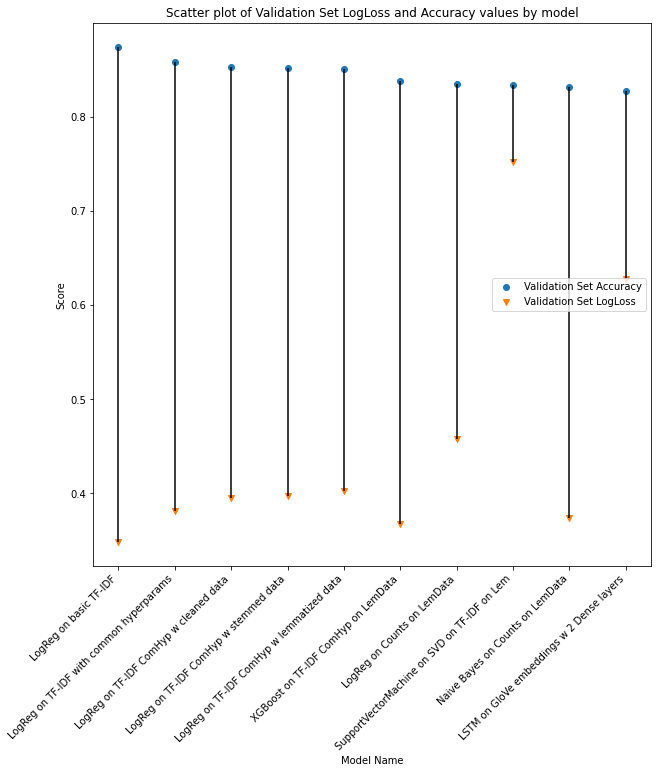

In [ ]:
# cvscores = []

# cvscorevals = [eval(x) for x in cvscores]

# for model, scorename in zip(models, cvscores):
#     print('{}: {}: {:.4}%'.format(model, scorename, 100*float(eval(scorename))))
    
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45, ha='right')

plt.scatter(shortModelNames, finacc, label = 'Validation Set Accuracy')#, markersize=4
plt.scatter(shortModelNames, finlogloss, marker = 'v', label='Validation Set LogLoss')

plt.vlines(shortModelNames, finlogloss, finacc)

plt.title("Scatter plot of Validation Set LogLoss and Accuracy values by model")
plt.xticks(range(0, len(shortModelNames)), shortModelNames)
plt.xlabel('Model Name')
plt.ylabel('Score')
plt.legend(loc=5)
plt.show()

# Word Salience Investigation

In [ ]:
nb_model_fin = finalModel_2

In [ ]:
#adapted from: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
#get priors
prob_pos = np.exp(nb_model_fin.class_log_prior_[1])
prob_neg = np.exp(nb_model_fin.class_log_prior_[0])
prob_nonneg = prob_pos

df_nbf = pd.DataFrame(index = ctv.get_feature_names())
#df_nbf.index = tfv.get_feature_names()
# Convert log probabilities to probabilities. 
df_nbf['pos'] = np.e**(nb_model_fin.feature_log_prob_[0, :])
df_nbf['neg'] = np.e**(nb_model_fin.feature_log_prob_[1, :])


df_nbf['odds_positive'] = (nb_model_fin.feature_log_prob_[0, :])/(nb_model_fin.feature_log_prob_[1, :])*(prob_nonneg/prob_neg)

df_nbf['odds_negative'] = (nb_model_fin.feature_log_prob_[1, :])/(nb_model_fin.feature_log_prob_[0, :])*(prob_neg/prob_nonneg)


# Here are the top5 most important words of your positive class:
odds_pos_top5 = df_nbf.sort_values('odds_positive',ascending=False)['odds_positive'][:20]
# Here are the top5 most important words of your negative class:
odds_neg_top5 = df_nbf.sort_values('odds_negative',ascending=False)['odds_negative'][:20]


In [ ]:
display(np.exp(nb_model_fin.class_log_prior_[1]))
display(np.exp(nb_model_fin.class_log_prior_[0]))
display(np.e**(nb_model_fin.feature_log_prob_[0, :]))
display(np.e**(nb_model_fin.feature_log_prob_[1, :]))
nb_model_fin.feature_log_prob_[0, :]

0.5698156352722604

0.4301843647277412

array([5.79135071e-05, 2.61544871e-05, 1.86817765e-06, ...,
       1.86817765e-06, 1.86817765e-06, 1.86817765e-06])

array([3.16136059e-05, 4.58397285e-05, 3.16136059e-06, ...,
       3.16136059e-06, 3.16136059e-06, 3.16136059e-06])

array([ -9.75655992, -10.55148979, -13.19054712, ..., -13.19054712,
       -13.19054712, -13.19054712])

In [ ]:
odds_pos_top5

pootis                 2.770402
nope                   2.327870
deadtaken              2.139944
muchi                  1.944433
attackforwardstrong    1.889522
ozfortress             1.760639
blueprint              1.755544
creativerse            1.744272
beatle                 1.736465
snowboard              1.729584
deca                   1.729140
ship                   1.728214
ffb                    1.723284
sector                 1.716479
bros                   1.713147
hat                    1.712518
poe                    1.710886
hereneeda              1.709227
diablo                 1.706307
demoman                1.701827
Name: odds_positive, dtype: float64

In [ ]:
odds_neg_top5.index

Index(['rakovina', 'virus', 'megabot', 'freejam', 'robocraft', 'crashcrash',
       'gaijin', 'robit', 'agent', 'rb', 'disconnected', 'crate', 'rp',
       'squeeze', 'authorization', 'fck', 'fj', 'teir', 'infuriate',
       'nowsende'],
      dtype='object')

In [ ]:
#reverse engineer a word cloud:
salience_pos_words=[]
salience_neg_words=[]
for w in odds_pos_top5.index:
  #print(odds_pos_top5[w])
  for _ in range(round(odds_pos_top5[w]*1000)):
    salience_pos_words.append(w)

for w in odds_neg_top5.index:
  #print(odds_neg_top5[w])
  for _ in range(round(odds_neg_top5[w]*1000)):
    salience_neg_words.append(w)

sal_pos = ' '.join(salience_pos_words)
sal_neg = ' '.join(salience_neg_words)

salience_pos = ''
randcap=len(salience_pos_words)
for i in range(len(salience_pos_words)):
  salience_pos+=(salience_pos_words.pop(random.randrange(0,randcap))+' ')
  randcap-=1

salience_neg = ''
randcap=len(salience_neg_words)
for i in range(len(salience_neg_words)):
  salience_neg+=(salience_neg_words.pop(random.randrange(0,randcap))+' ')
  randcap-=1

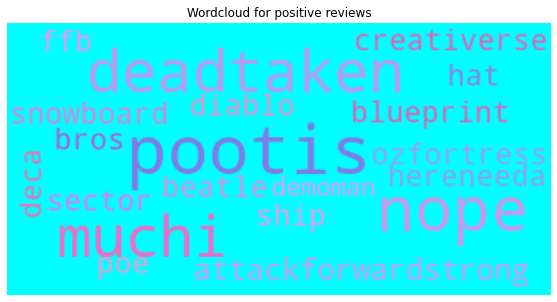

In [ ]:
##pos salience wordcloud
wordcloud = WordCloud(max_font_size=50, background_color=bc, color_func=purple_color_func, stopwords=STOPWORDS).generate(salience_pos)

plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for {} reviews'.format('positive'))

plt.show()

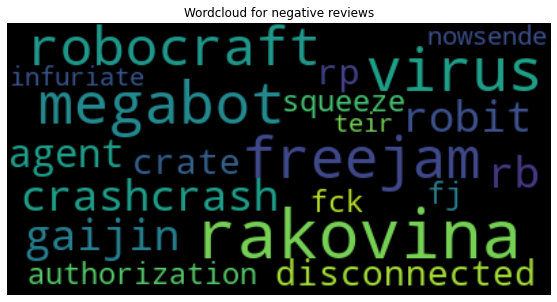

In [ ]:
##neg salience wordcloud
wordcloud = WordCloud(max_font_size=50, stopwords=STOPWORDS).generate(salience_neg)

plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for {} reviews'.format('negative'))

plt.show()